# Machine Learning

Anggota Kelompok :

1. Haidar Dimas Heryanto - 2022210370311088
2. Alfi Aulia Azzahra - 202210370311095

# PART 1: KLASIK ML

## INSTALL & IMPORT LIBRARIES

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
!pip install -q roboflow albumentations opencv-python scikit-learn scikit-image matplotlib seaborn imbalanced-learn

import os
import shutil
import cv2
import yaml
import numpy as np
import pandas as pd
import random
import albumentations as A
from roboflow import Roboflow
from skimage.feature import hog, local_binary_pattern, graycomatrix, graycoprops
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
from collections import Counter

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [33]:
def set_all_seeds(seed=42):
    """Set semua random seeds untuk reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    print(f"\n🎲 All random seeds set to: {seed}")
    print("   ✓ Results will be reproducible across runs!")


set_all_seeds(42)


🎲 All random seeds set to: 42
   ✓ Results will be reproducible across runs!


## LOAD DATASET DARI ROBOFLOW

In [34]:
rf = Roboflow(api_key="9J11qljgG9odzZnvoVbg")
project = rf.workspace("aa-cqfub").project("h3lm-40l0-oid-xd-3dofr")
version = project.version(5)
dataset = version.download("yolov11")

# Target classes (pakai 2 label saja)
TARGET_CLASSES = {1: 0, 5: 1}  # 1=no_helmet→0, 5=with_helmet→1
CLASS_NAMES = ['no_helmet', 'with_helmet']

print(f"\n✅ Dataset downloaded!")
print(f"📁 Location: {dataset.location}")
print(f"🎯 Target Classes: {CLASS_NAMES}")

loading Roboflow workspace...
loading Roboflow project...

✅ Dataset downloaded!
📁 Location: /content/h3Lm-40L0-Oid-XD-5
🎯 Target Classes: ['no_helmet', 'with_helmet']


## PREPROCESSING & AUGMENTASI

In [35]:
transform_crop = A.Compose([
    A.Resize(128, 128),
    A.GaussianBlur(blur_limit=(3, 5), p=0.3),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=20, p=0.5),
])

print("✅ Preprocessing pipeline created:")
print("   • Resize: 128x128")
print("   • Gaussian Blur (noise reduction)")
print("   • Horizontal Flip")
print("   • Rotation ±15°")
print("   • Brightness/Contrast adjustment")
print("   • HSV color shift")
print("   • Seeded for reproducibility ✓")

✅ Preprocessing pipeline created:
   • Resize: 128x128
   • Gaussian Blur (noise reduction)
   • Horizontal Flip
   • Rotation ±15°
   • Brightness/Contrast adjustment
   • HSV color shift
   • Seeded for reproducibility ✓


### HELPER FUNCTIONS

In [36]:
# @title
def yolo_to_bbox(x_center, y_center, width, height, img_width, img_height):
    """Convert YOLO format to pixel coordinates"""
    x_center *= img_width
    y_center *= img_height
    width *= img_width
    height *= img_height

    x1 = int(max(0, x_center - width / 2))
    y1 = int(max(0, y_center - height / 2))
    x2 = int(min(img_width, x_center + width / 2))
    y2 = int(min(img_height, y_center + height / 2))

    return x1, y1, x2, y2

def run_experiment(X, y, feature_name, algorithms_dict, show_plots=True):
    """Run experiments with multiple algorithms"""
    print(f"🧪 RUNNING EXPERIMENTS: {feature_name}")

    results = []

    # Split data
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
    )

    print(f"📊 Data Split: Train={len(y_train)}, Val={len(y_val)}, Test={len(y_test)}")
    print(f"   Train distribution: {np.bincount(y_train).tolist()}")

    # SMOTE
    class_counts = np.bincount(y_train)
    if abs(class_counts[0] - class_counts[1]) > 50:
        target_count = max(class_counts)
        try:
            smote = SMOTE(random_state=42, k_neighbors=5,
                         sampling_strategy={0: target_count, 1: target_count})
            X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)
            print(f"⚖️ SMOTE applied: {len(y_train)} → {len(y_train_bal)}")
        except:
            X_train_bal, y_train_bal = X_train, y_train
    else:
        X_train_bal, y_train_bal = X_train, y_train

    # Normalize
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_bal)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # PCA
    pca = PCA(n_components=0.95, random_state=42)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_val_pca = pca.transform(X_val_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    print(f"📉 PCA: {X.shape[1]} → {X_train_pca.shape[1]} features (95% variance)")

    # Train & evaluate each algorithm
    for algo_name, algorithm in algorithms_dict.items():
        print(f"\n  🔹 Training {algo_name}...")

        start = time.time()
        algorithm.fit(X_train_pca, y_train_bal)
        train_time = time.time() - start

        train_acc = accuracy_score(y_train_bal, algorithm.predict(X_train_pca))
        val_acc = accuracy_score(y_val, algorithm.predict(X_val_pca))
        test_acc = accuracy_score(y_test, algorithm.predict(X_test_pca))

        print(f"     Train: {train_acc:.4f} | Val: {val_acc:.4f} | Test: {test_acc:.4f} | Time: {train_time:.2f}s")

        results.append({
            'algorithm': algo_name,
            'train_acc': train_acc,
            'val_acc': val_acc,
            'test_acc': test_acc,
            'overfitting': train_acc - test_acc,
            'train_time': train_time,
            'model': algorithm,
            'scaler': scaler,
            'pca': pca,
            'y_test': y_test,
            'y_pred': algorithm.predict(X_test_pca)
        })

    # Find best
    best = max(results, key=lambda x: x['test_acc'])

    # Plot results
    if show_plots:
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        # Confusion matrix
        cm = confusion_matrix(best['y_test'], best['y_pred'])
        sns.heatmap(cm, annot=True, fmt='d', cmap='RdYlGn',
                   xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, ax=axes[0])
        axes[0].set_title(f"{feature_name}\nBest: {best['algorithm']} - Acc: {best['test_acc']:.2%}",
                         fontweight='bold')
        axes[0].set_ylabel('True Label')
        axes[0].set_xlabel('Predicted Label')

        # Bar comparison
        test_accs = [r['test_acc'] for r in results]
        algo_names = [r['algorithm'] for r in results]
        colors = ['#6bcf7f' if acc == max(test_accs) else '#ffd93d' if acc > 0.75 else '#ff6b6b'
                 for acc in test_accs]

        axes[1].barh(algo_names, test_accs, color=colors, edgecolor='black')
        axes[1].set_xlabel('Test Accuracy')
        axes[1].set_title(f'{feature_name} - Algorithms Comparison', fontweight='bold')
        axes[1].axvline(x=0.75, color='red', linestyle='--', alpha=0.5, label='75%')
        axes[1].legend()
        axes[1].grid(axis='x', alpha=0.3)

        for i, v in enumerate(test_accs):
            axes[1].text(v + 0.01, i, f'{v:.1%}', va='center', fontweight='bold')

        plt.tight_layout()
        plt.savefig(f"{feature_name.lower().replace(' ', '_').replace(':', '')}_results.png",
                   dpi=300, bbox_inches='tight')
        print(f"\n✅ Plot saved: {feature_name.lower().replace(' ', '_').replace(':', '')}_results.png")
        plt.show()

        # Classification report
        print(f"\n📋 Classification Report - Best Model ({best['algorithm']}):")
        print(classification_report(best['y_test'], best['y_pred'],
                                   target_names=CLASS_NAMES, zero_division=0))

    return results, best

def save_best_model(best_result, set_name, feature_extractor_func):
    """Save best model for each feature set"""
    filename = f"best_model_{set_name.lower().replace(' ', '_').replace(':', '')}.pkl"

    with open(filename, 'wb') as f:
        pickle.dump({
            'model': best_result['model'],
            'scaler': best_result['scaler'],
            'pca': best_result['pca'],
            'feature_set': set_name,
            'algorithm': best_result['algorithm'],
            'feature_extractor': feature_extractor_func,
            'class_names': CLASS_NAMES,
            'test_acc': best_result['test_acc'],
            'val_acc': best_result['val_acc'],
            'train_acc': best_result['train_acc'],
            'overfitting': best_result['overfitting']
        }, f)

    print(f"✅ Model saved: {filename}")
    return filename

print("✅ Helper functions defined!")

✅ Helper functions defined!


### CROP BBOXES (MULTIPLE LABELS)

> pada sebuah citra jika terdapat 2 label, perlabel akan di crop dan dijadikan citra baru. agar menyesuaikan jumlah label yg ada di roboflow (kuliat sama sih jumlahe). dan semua label terbaca walaupun dalam satu citra terdapat multilabel

In [37]:
def load_cropped_data(dataset_path, augmentation_seed=42):

    print("📦 Loading and cropping bboxes")

    all_images = []
    all_labels = []
    total_bboxes = 0
    aug_counter = 0

    for split in ['train', 'valid', 'test']:
        img_folder = os.path.join(dataset_path, split, "images")
        label_folder = os.path.join(dataset_path, split, "labels")

        if not os.path.exists(img_folder):
            continue

        image_files = sorted([f for f in os.listdir(img_folder)
                             if f.endswith(('.jpg', '.png'))])

        for img_file in image_files:
            img_path = os.path.join(img_folder, img_file)
            label_path = os.path.join(label_folder,
                                     img_file.replace('.jpg', '.txt').replace('.png', '.txt'))

            image = cv2.imread(img_path)
            if image is None:
                continue

            img_height, img_width = image.shape[:2]
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            if not os.path.exists(label_path):
                continue

            with open(label_path, 'r') as f:
                lines = f.readlines()
                lines = sorted(lines)

                for line in lines:
                    parts = line.strip().split()
                    if len(parts) == 5:
                        cls = int(parts[0])

                        if cls not in TARGET_CLASSES:
                            continue

                        x_c, y_c, w, h = map(float, parts[1:])
                        x1, y1, x2, y2 = yolo_to_bbox(x_c, y_c, w, h, img_width, img_height)

                        if (x2 - x1) < 10 or (y2 - y1) < 10:
                            continue

                        cropped = image_rgb[y1:y2, x1:x2]
                        if cropped.size == 0:
                            continue

                        try:

                            random.seed(augmentation_seed + aug_counter)
                            np.random.seed(augmentation_seed + aug_counter)

                            aug = transform_crop(image=cropped)
                            aug_img = np.clip(aug['image'], 0, 255).astype(np.uint8)
                            aug_img = cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR)

                            all_images.append(aug_img)
                            all_labels.append(TARGET_CLASSES[cls])
                            total_bboxes += 1
                            aug_counter += 1
                        except:
                            continue

    print(f"✅ Processed: {total_bboxes} bboxes")
    print(f"   Distribution: {np.bincount(all_labels).tolist()} (0=no_helmet, 1=with_helmet)")
    print(f"   🎲 Used augmentation seeds: {augmentation_seed} to {augmentation_seed + aug_counter - 1}")

    return all_images, np.array(all_labels)

# Load cropped images dengan seed
cropped_images, labels = load_cropped_data(dataset.location, augmentation_seed=42)
print(f"\n✅ Total cropped bboxes: {len(cropped_images)}")

assert len(cropped_images) == len(labels), f"Mismatch! Images: {len(cropped_images)}, Labels: {len(labels)}"


📦 Loading and cropping bboxes
✅ Processed: 1334 bboxes
   Distribution: [832, 502] (0=no_helmet, 1=with_helmet)
   🎲 Used augmentation seeds: 42 to 1375

✅ Total cropped bboxes: 1334


> no_helmet	= 837 || with_helmet	= 502

ini dari jumlah label yg ada di roboflow (beda dikit ternyata, kayanya bisa jadi gara-gara label e terlalu kecil)

#### Contoh hasil crop



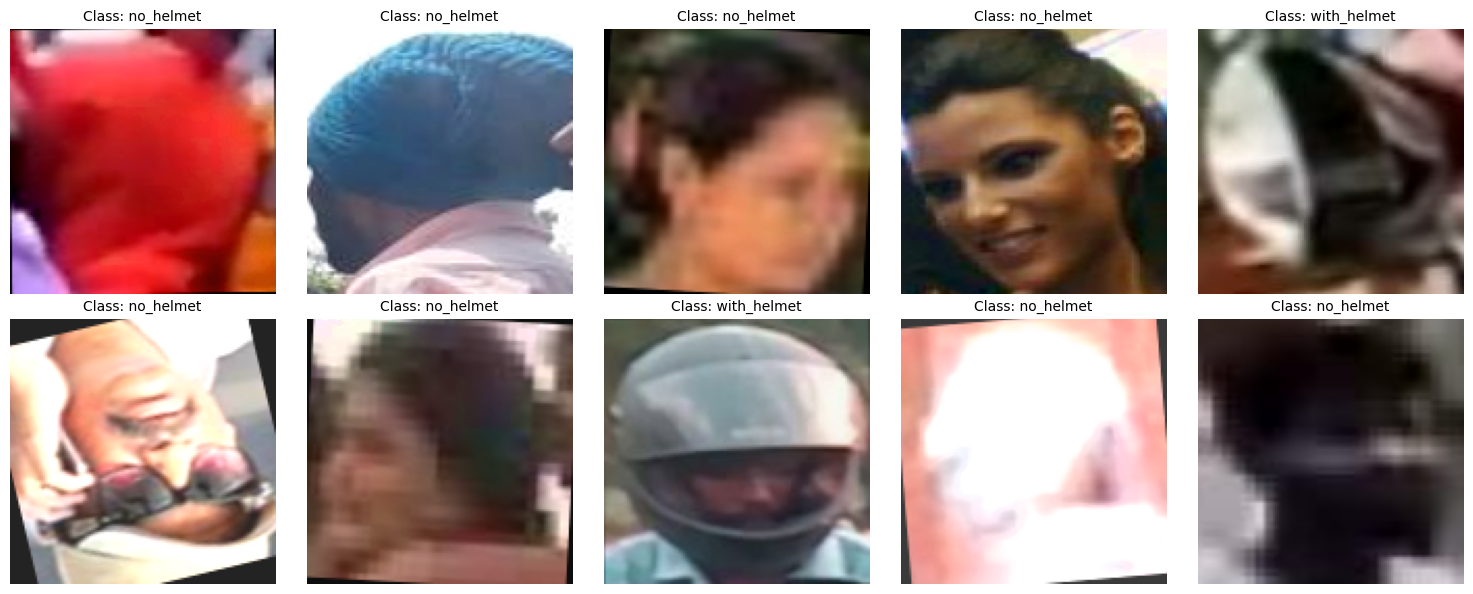

In [38]:
# @title
num_examples = 10
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

# Get class names from the loaded dataset config or define them
# Assuming CLASS_NAMES is already defined as ['no_helmet', 'with_helmet']
# If not, uncomment the following lines to load from data.yaml
# original_yaml = os.path.join(dataset.location, "data.yaml")
# with open(original_yaml, 'r') as f:
#     data_config = yaml.safe_load(f)
# CLASS_NAMES = data_config['names'] # Make sure this matches your TARGET_CLASSES mapping


# Select random indices
random_indices = np.random.choice(len(cropped_images), num_examples, replace=False)

for i, idx in enumerate(random_indices):
    img = cropped_images[idx]
    label = labels[idx]
    class_name = CLASS_NAMES[label]

    axes[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[i].set_title(f"Class: {class_name}", fontsize=10)
    axes[i].axis('off')

plt.tight_layout()
plt.show()


## Future Extraction

Terdapat 3 set eksperimen. per set masing-masing menerapkan 3 filter klasik dan 4 algoritma




###  SET 1: HISTOGRAM + HOG + LBP

📊 Extracting features...
✅ Features extracted: (1334, 8222)
   • Histogram: 96 features (32 bins × 3 channels)
   • HOG: ~8100 features
   • LBP: ~26 features
🧪 RUNNING EXPERIMENTS: SET 1: Histogram+HOG+LBP
📊 Data Split: Train=1067, Val=133, Test=134
   Train distribution: [665, 402]
⚖️ SMOTE applied: 1067 → 1330
📉 PCA: 8222 → 738 features (95% variance)

  🔹 Training SVM-RBF...
     Train: 0.9977 | Val: 0.8271 | Test: 0.7836 | Time: 0.55s

  🔹 Training SVM-Linear...
     Train: 1.0000 | Val: 0.7444 | Test: 0.6940 | Time: 0.37s

  🔹 Training RandomForest...
     Train: 1.0000 | Val: 0.6541 | Test: 0.6642 | Time: 3.35s

  🔹 Training GradientBoosting...
     Train: 1.0000 | Val: 0.7519 | Test: 0.6343 | Time: 77.76s

✅ Plot saved: set_1_histogram+hog+lbp_results.png


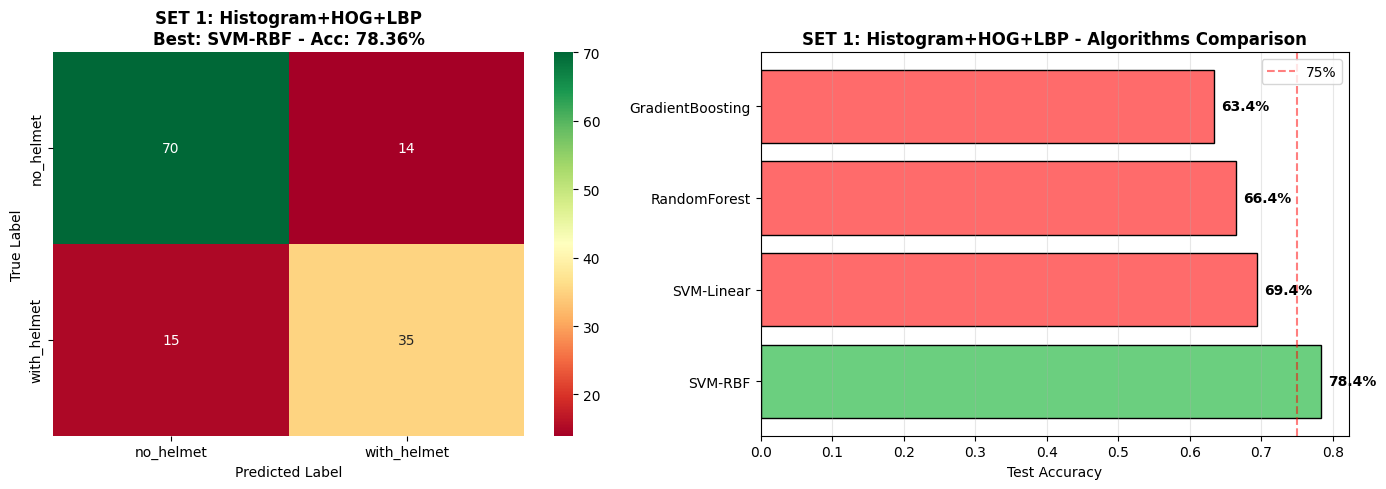


📋 Classification Report - Best Model (SVM-RBF):
              precision    recall  f1-score   support

   no_helmet       0.82      0.83      0.83        84
 with_helmet       0.71      0.70      0.71        50

    accuracy                           0.78       134
   macro avg       0.77      0.77      0.77       134
weighted avg       0.78      0.78      0.78       134

✅ Model saved: best_model_set_1.pkl
✅ Saved 'best_model_set_1.pkl' to Google Drive.


In [39]:
def extract_set1_features(image):
    """Feature Set 1: Histogram + HOG + LBP"""
    # Histogram (Color Distribution)
    hist_features = []
    for i in range(3):
        hist = cv2.calcHist([image], [i], None, [32], [0, 256])
        hist = hist.flatten() / (hist.sum() + 1e-7)
        hist_features.extend(hist)

    # HOG (Shape/Edge)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hog_feat = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                   cells_per_block=(2, 2), block_norm='L2-Hys',
                   visualize=False, feature_vector=True)

    # LBP (Texture)
    lbp = local_binary_pattern(gray, 24, 3, method='uniform')
    n_bins = int(lbp.max() + 1)
    lbp_hist, _ = np.histogram(lbp, bins=n_bins, range=(0, n_bins), density=True)

    return np.concatenate([hist_features, hog_feat, lbp_hist])

print("📊 Extracting features...")
X_set1 = np.array([extract_set1_features(img) for img in cropped_images])
print(f"✅ Features extracted: {X_set1.shape}")
print(f"   • Histogram: 96 features (32 bins × 3 channels)")
print(f"   • HOG: ~{X_set1.shape[1] - 122} features")
print(f"   • LBP: ~26 features")

# Define algorithms
algorithms_set1 = {
    'SVM-RBF': SVC(kernel='rbf', C=1.0, gamma='scale', class_weight='balanced', random_state=42),
    'SVM-Linear': SVC(kernel='linear', C=0.5, class_weight='balanced', random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=42)
}

# Run experiments
results_set1, best_set1 = run_experiment(X_set1, labels, "SET 1: Histogram+HOG+LBP", algorithms_set1)

# Define Google Drive save path
drive_save_path = "/content/drive/MyDrive/jurnal YOLO/Machine Learning/hasil colab"
os.makedirs(drive_save_path, exist_ok=True)

# Save best model SET 1
saved_file_set1 = save_best_model(best_set1, "SET 1", extract_set1_features)
shutil.move(saved_file_set1, os.path.join(drive_save_path, os.path.basename(saved_file_set1)))
print(f"✅ Saved '{os.path.basename(saved_file_set1)}' to Google Drive.")

### SET 2: COLOR MOMENTS + HOG + GLCM

📊 Extracting features...
✅ Features extracted: (1334, 1793)
   • Color Moments: 9 features (mean, std, skew × 3 channels)
   • HOG: ~1764 features
   • GLCM: ~20 features
🧪 RUNNING EXPERIMENTS: SET 2: ColorMoments+HOG+GLCM
📊 Data Split: Train=1067, Val=133, Test=134
   Train distribution: [665, 402]
⚖️ SMOTE applied: 1067 → 1330
📉 PCA: 1793 → 362 features (95% variance)

  🔹 Training SVM-RBF...
     Train: 0.9925 | Val: 0.8346 | Test: 0.8209 | Time: 0.26s

  🔹 Training SVM-Linear...
     Train: 0.9932 | Val: 0.7218 | Test: 0.7239 | Time: 1.87s

  🔹 Training RandomForest...
     Train: 1.0000 | Val: 0.6391 | Test: 0.6418 | Time: 2.00s

  🔹 Training GradientBoosting...
     Train: 1.0000 | Val: 0.6541 | Test: 0.7313 | Time: 38.28s

✅ Plot saved: set_2_colormoments+hog+glcm_results.png


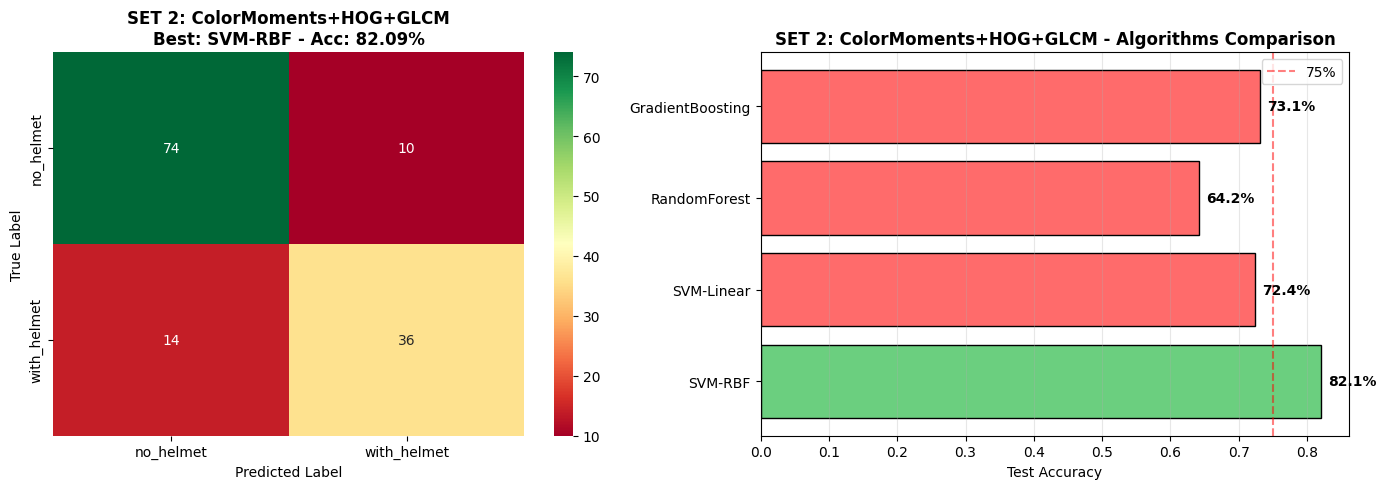


📋 Classification Report - Best Model (SVM-RBF):
              precision    recall  f1-score   support

   no_helmet       0.84      0.88      0.86        84
 with_helmet       0.78      0.72      0.75        50

    accuracy                           0.82       134
   macro avg       0.81      0.80      0.81       134
weighted avg       0.82      0.82      0.82       134

✅ Model saved: best_model_set_2.pkl
✅ Saved 'best_model_set_2.pkl' to Google Drive.


In [40]:
def extract_set2_features(image):
    """Feature Set 2: Color Moments + HOG + GLCM"""
    features = []

    # Color Moments (Mean, Std, Skewness)
    for i in range(3):
        channel = image[:,:,i].astype(np.float64)
        mean_val = np.mean(channel)
        std_val = np.std(channel)
        centered = channel - mean_val
        skew_val = np.mean(centered**3) / (std_val**3 + 1e-7)
        features.extend([mean_val, std_val, skew_val])

    # HOG (optimized)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hog_feat = hog(gray, orientations=9, pixels_per_cell=(16, 16),
                   cells_per_block=(2, 2), block_norm='L2-Hys',
                   visualize=False, feature_vector=True)

    # GLCM (Texture)
    gray_norm = (gray / 16).astype(np.uint8)
    glcm = graycomatrix(gray_norm, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                        levels=16, symmetric=True, normed=True)

    glcm_features = []
    for prop in ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']:
        glcm_features.extend(graycoprops(glcm, prop).flatten())

    return np.concatenate([features, hog_feat, glcm_features])

print("📊 Extracting features...")
X_set2 = np.array([extract_set2_features(img) for img in cropped_images])
print(f"✅ Features extracted: {X_set2.shape}")
print(f"   • Color Moments: 9 features (mean, std, skew × 3 channels)")
print(f"   • HOG: ~{X_set2.shape[1] - 29} features")
print(f"   • GLCM: ~20 features")

algorithms_set2 = {
    'SVM-RBF': SVC(kernel='rbf', C=1.0, gamma='scale', class_weight='balanced', random_state=42),
    'SVM-Linear': SVC(kernel='linear', C=0.5, class_weight='balanced', random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=42)
}

results_set2, best_set2 = run_experiment(X_set2, labels, "SET 2: ColorMoments+HOG+GLCM", algorithms_set2)

# Define Google Drive save path
drive_save_path = "/content/drive/MyDrive/jurnal YOLO/Machine Learning/hasil colab"
os.makedirs(drive_save_path, exist_ok=True)

# Save best model SET 2
saved_file_set2 = save_best_model(best_set2, "SET 2", extract_set2_features)
shutil.move(saved_file_set2, os.path.join(drive_save_path, os.path.basename(saved_file_set2)))
print(f"✅ Saved '{os.path.basename(saved_file_set2)}' to Google Drive.")

### SET 3: EDGE + HOG + COLOR HISTOGRAM

📊 Extracting features...
✅ Features extracted: (1334, 1621)
   • Edge Features: 5 features (Canny + Sobel)
   • HOG: ~1568 features
   • Color Histogram: 48 features (16 bins × 3 channels)
🧪 RUNNING EXPERIMENTS: SET 3: Edge+HOG+ColorHist
📊 Data Split: Train=1067, Val=133, Test=134
   Train distribution: [665, 402]
⚖️ SMOTE applied: 1067 → 1330
📉 PCA: 1621 → 350 features (95% variance)

  🔹 Training SVM-RBF...
     Train: 0.9902 | Val: 0.8421 | Test: 0.7687 | Time: 0.29s

  🔹 Training SVM-Linear...
     Train: 0.9992 | Val: 0.7444 | Test: 0.6866 | Time: 0.86s

  🔹 Training RandomForest...
     Train: 1.0000 | Val: 0.6917 | Test: 0.6866 | Time: 1.92s

  🔹 Training GradientBoosting...
     Train: 1.0000 | Val: 0.7444 | Test: 0.6716 | Time: 37.93s

✅ Plot saved: set_3_edge+hog+colorhist_results.png


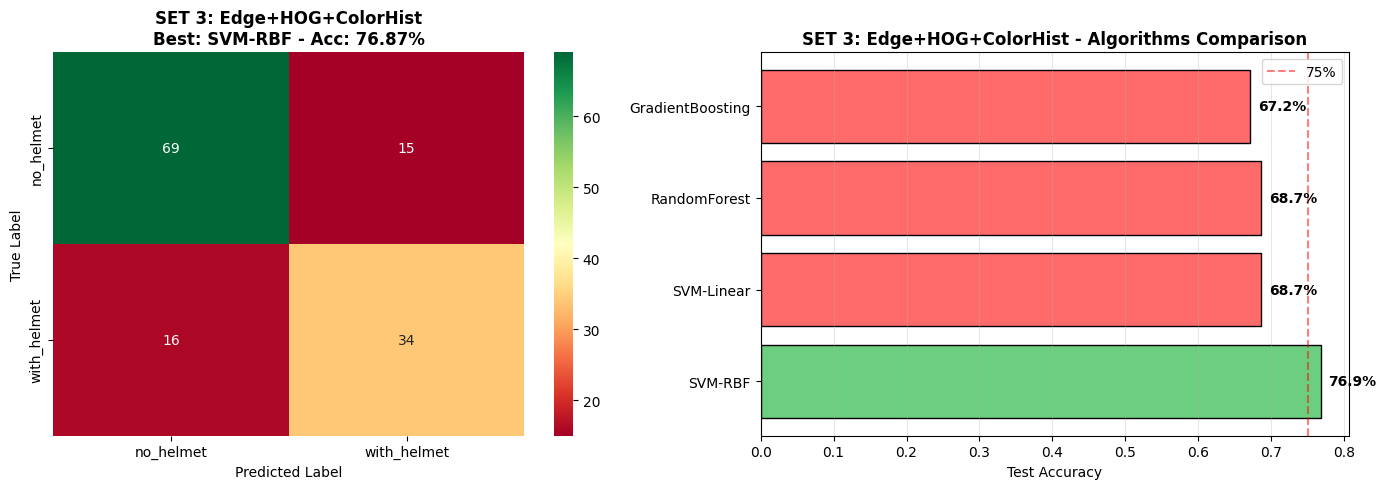


📋 Classification Report - Best Model (SVM-RBF):
              precision    recall  f1-score   support

   no_helmet       0.81      0.82      0.82        84
 with_helmet       0.69      0.68      0.69        50

    accuracy                           0.77       134
   macro avg       0.75      0.75      0.75       134
weighted avg       0.77      0.77      0.77       134

✅ Model saved: best_model_set_3.pkl
✅ Saved 'best_model_set_3.pkl' to Google Drive.


In [41]:
def extract_set3_features(image):
    """Feature Set 3: Edge + HOG + Color Histogram"""
    features = []
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Edge Features (Canny + Sobel)
    edges_canny = cv2.Canny(gray, 50, 150)
    features.extend([
        np.sum(edges_canny > 0) / edges_canny.size,
        np.mean(edges_canny),
        np.std(edges_canny)
    ])

    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    features.extend([np.mean(np.abs(sobelx)), np.mean(np.abs(sobely))])

    # HOG (compact)
    hog_feat = hog(gray, orientations=8, pixels_per_cell=(16, 16),
                   cells_per_block=(2, 2), block_norm='L2-Hys',
                   visualize=False, feature_vector=True)

    # Color Histogram (reduced)
    hist_features = []
    for i in range(3):
        hist = cv2.calcHist([image], [i], None, [16], [0, 256])
        hist = hist.flatten() / (hist.sum() + 1e-7)
        hist_features.extend(hist)

    return np.concatenate([features, hog_feat, hist_features])

print("📊 Extracting features...")
X_set3 = np.array([extract_set3_features(img) for img in cropped_images])
print(f"✅ Features extracted: {X_set3.shape}")
print(f"   • Edge Features: 5 features (Canny + Sobel)")
print(f"   • HOG: ~{X_set3.shape[1] - 53} features")
print(f"   • Color Histogram: 48 features (16 bins × 3 channels)")

algorithms_set3 = {
    'SVM-RBF': SVC(kernel='rbf', C=1.0, gamma='scale', class_weight='balanced', random_state=42),
    'SVM-Linear': SVC(kernel='linear', C=0.5, class_weight='balanced', random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=42)
}

results_set3, best_set3 = run_experiment(X_set3, labels, "SET 3: Edge+HOG+ColorHist", algorithms_set3)

# Define Google Drive save path
drive_save_path = "/content/drive/MyDrive/jurnal YOLO/Machine Learning/hasil colab"
os.makedirs(drive_save_path, exist_ok=True)

# Save best model SET 3
saved_file_set3 = save_best_model(best_set3, "SET 3", extract_set3_features)
shutil.move(saved_file_set3, os.path.join(drive_save_path, os.path.basename(saved_file_set3)))
print(f"✅ Saved '{os.path.basename(saved_file_set3)}' to Google Drive.")

In [42]:

print("📊 MENGHITUNG PRECISION & RECALL")

from sklearn.metrics import precision_score, recall_score

# Hitung untuk best model dari setiap set
for set_name, best_result in [('SET 1', best_set1), ('SET 2', best_set2), ('SET 3', best_set3)]:
    y_true = best_result['y_test']
    y_pred = best_result['y_pred']

    # Calculate metrics
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)

    # Add to best_result dictionary
    best_result['precision'] = precision
    best_result['recall'] = recall

    print(f"\n{set_name}:")
    print(f"   Precision: {precision:.6f}")
    print(f"   Recall: {recall:.6f}")

print("\n✅ Precision & Recall updated for all Traditional ML sets!")

📊 MENGHITUNG PRECISION & RECALL

SET 1:
   Precision: 0.782767
   Recall: 0.783582

SET 2:
   Precision: 0.819155
   Recall: 0.820896

SET 3:
   Precision: 0.767777
   Recall: 0.768657

✅ Precision & Recall updated for all Traditional ML sets!


## Perbandingan Semua Set


📋 TABEL PERBANDINGAN:


,Feature Set,Algorithm,Test Acc,Val Acc,Train Acc,Overfitting,Time (s)
0,SET 1,SVM-RBF,78.36%,82.71%,99.77%,21.42%,0.55
1,SET 1,SVM-Linear,69.40%,74.44%,100.00%,30.60%,0.37
2,SET 1,RandomForest,66.42%,65.41%,100.00%,33.58%,3.35
3,SET 1,GradientBoosting,63.43%,75.19%,100.00%,36.57%,77.76
4,SET 2,SVM-RBF,82.09%,83.46%,99.25%,17.16%,0.26
5,SET 2,SVM-Linear,72.39%,72.18%,99.32%,26.94%,1.87
6,SET 2,RandomForest,64.18%,63.91%,100.00%,35.82%,2.00
7,SET 2,GradientBoosting,73.13%,65.41%,100.00%,26.87%,38.28
8,SET 3,SVM-RBF,76.87%,84.21%,99.02%,22.16%,0.29
9,SET 3,SVM-Linear,68.66%,74.44%,99.92%,31.27%,0.86



🏆 BEST OVERALL:
   Feature Set: SET 2
   Algorithm: SVM-RBF
   Test Accuracy: 82.09%
   Val Accuracy: 83.46%
   Overfitting: 17.16%
✅ Saved: /content/drive/MyDrive/jurnal YOLO/Machine Learning/hasil colab/complete_analysis_all_sets.png


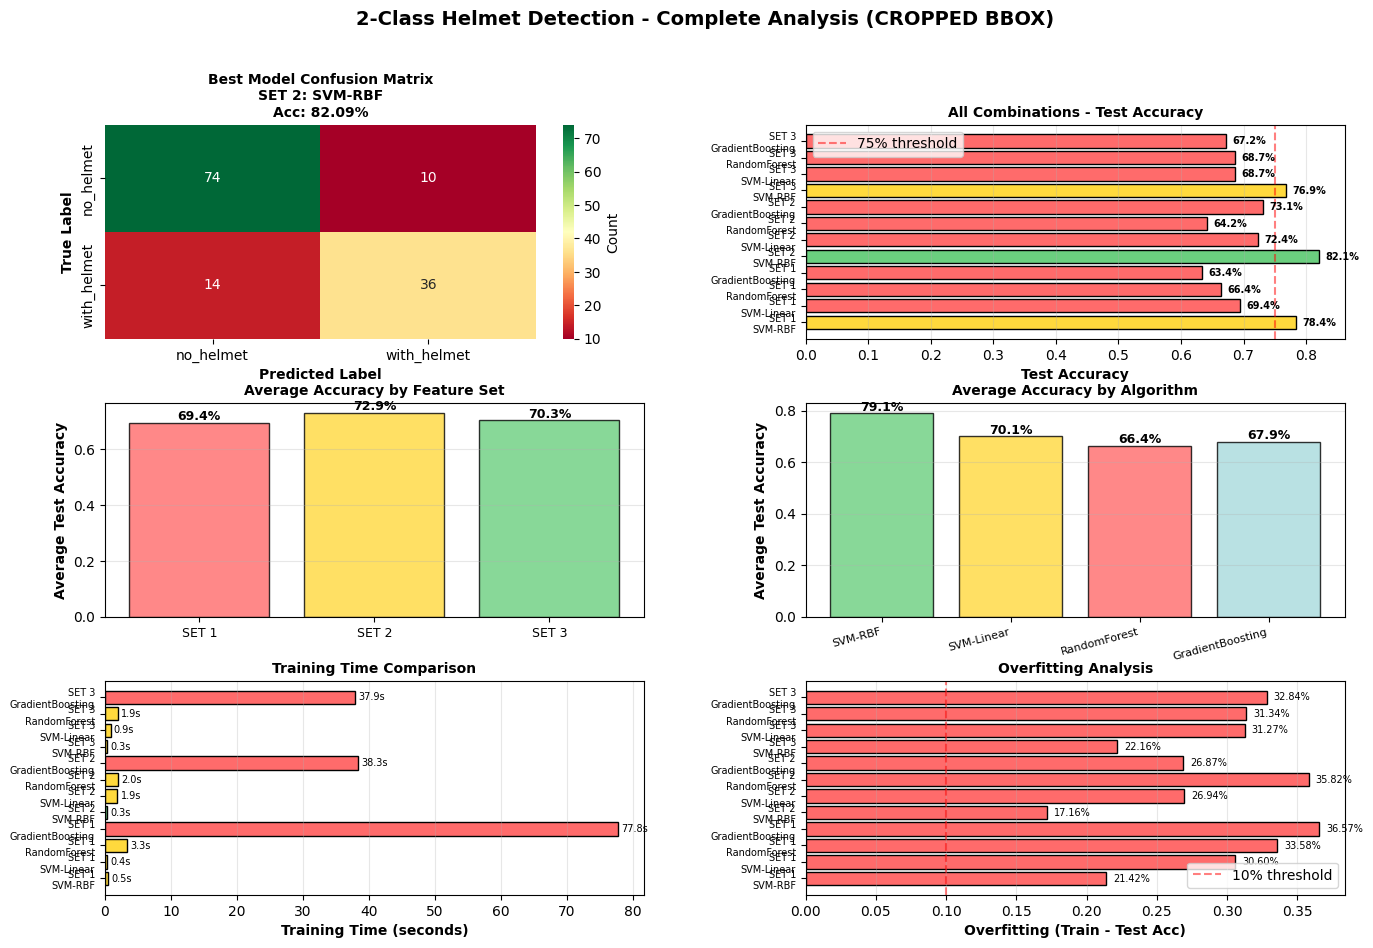

In [43]:
# @title
# Compile all results
all_results = []
for set_name, results in [('SET 1', results_set1), ('SET 2', results_set2), ('SET 3', results_set3)]:
    for r in results:
        all_results.append({
            'Feature Set': set_name,
            'Algorithm': r['algorithm'],
            'Test Acc': f"{r['test_acc']:.2%}",
            'Val Acc': f"{r['val_acc']:.2%}",
            'Train Acc': f"{r['train_acc']:.2%}",
            'Overfitting': f"{r['overfitting']:.2%}",
            'Time (s)': f"{r['train_time']:.2f}",
            'test_acc_float': r['test_acc']  # For sorting
        })

# Display table
df_comparison = pd.DataFrame(all_results)
print("\n📋 TABEL PERBANDINGAN:")
display(df_comparison.drop('test_acc_float', axis=1))

# Find overall best
best_overall = max([best_set1, best_set2, best_set3], key=lambda x: x['test_acc'])
set_names_dict = {id(best_set1): 'SET 1', id(best_set2): 'SET 2', id(best_set3): 'SET 3'}

print(f"\n🏆 BEST OVERALL:")
print(f"   Feature Set: {set_names_dict[id(best_overall)]}")
print(f"   Algorithm: {best_overall['algorithm']}")
print(f"   Test Accuracy: {best_overall['test_acc']:.2%}")
print(f"   Val Accuracy: {best_overall['val_acc']:.2%}")
print(f"   Overfitting: {best_overall['overfitting']:.2%}")


fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# Convert all_results back to dict format for visualization
all_results_viz = []
for set_name, results in [('SET 1', results_set1), ('SET 2', results_set2), ('SET 3', results_set3)]:
    for r in results:
        all_results_viz.append({
            'feature': set_name,
            'algorithm': r['algorithm'],
            'test_acc': r['test_acc'],
            'val_acc': r['val_acc'],
            'train_acc': r['train_acc'],
            'overfitting': r['overfitting'],
            'train_time': r['train_time']
        })

# 1. Best Model Confusion Matrix
ax1 = fig.add_subplot(gs[0, 0])
cm = confusion_matrix(best_overall['y_test'], best_overall['y_pred'])
sns.heatmap(cm, annot=True, fmt='d', cmap='RdYlGn',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            ax=ax1, cbar_kws={'label': 'Count'})
ax1.set_title(f"Best Model Confusion Matrix\n{set_names_dict[id(best_overall)]}: {best_overall['algorithm']}\nAcc: {best_overall['test_acc']:.2%}",
              fontweight='bold', fontsize=10)
ax1.set_ylabel('True Label', fontweight='bold')
ax1.set_xlabel('Predicted Label', fontweight='bold')

# 2. All Models Test Accuracy Comparison
ax2 = fig.add_subplot(gs[0, 1])
test_accs = [r['test_acc'] for r in all_results_viz]
labels = [f"{r['feature']}\n{r['algorithm']}" for r in all_results_viz]
colors = ['#6bcf7f' if acc == max(test_accs) else '#ffd93d' if acc > 0.75 else '#ff6b6b' for acc in test_accs]

bars = ax2.barh(range(len(test_accs)), test_accs, color=colors, edgecolor='black')
ax2.set_yticks(range(len(labels)))
ax2.set_yticklabels(labels, fontsize=7)
ax2.set_xlabel('Test Accuracy', fontweight='bold')
ax2.set_title('All Combinations - Test Accuracy', fontweight='bold', fontsize=10)
ax2.axvline(x=0.75, color='red', linestyle='--', alpha=0.5, label='75% threshold')
ax2.legend()
ax2.grid(axis='x', alpha=0.3)

for i, v in enumerate(test_accs):
    ax2.text(v + 0.01, i, f'{v:.1%}', va='center', fontsize=7, fontweight='bold')

# 3. Accuracy by Feature Set
ax3 = fig.add_subplot(gs[1, 0])
set_names_list = ['SET 1', 'SET 2', 'SET 3']
set_avg_acc = []
for sn in set_names_list:
    accs = [r['test_acc'] for r in all_results_viz if r['feature'] == sn]
    set_avg_acc.append(np.mean(accs))

bars = ax3.bar(range(len(set_names_list)), set_avg_acc, color=['#ff6b6b', '#ffd93d', '#6bcf7f'],
               edgecolor='black', alpha=0.8)
ax3.set_xticks(range(len(set_names_list)))
ax3.set_xticklabels(set_names_list, fontsize=9, rotation=0)
ax3.set_ylabel('Average Test Accuracy', fontweight='bold')
ax3.set_title('Average Accuracy by Feature Set', fontweight='bold', fontsize=10)
ax3.grid(axis='y', alpha=0.3)

for i, v in enumerate(set_avg_acc):
    ax3.text(i, v + 0.01, f'{v:.1%}', ha='center', fontweight='bold', fontsize=9)

# 4. Accuracy by Algorithm
ax4 = fig.add_subplot(gs[1, 1])
algo_names = ['SVM-RBF', 'SVM-Linear', 'RandomForest', 'GradientBoosting']
algo_avg_acc = []
for an in algo_names:
    accs = [r['test_acc'] for r in all_results_viz if r['algorithm'] == an]
    algo_avg_acc.append(np.mean(accs))

bars = ax4.bar(range(len(algo_names)), algo_avg_acc, color=['#6bcf7f', '#ffd93d', '#ff6b6b', '#a8dadc'],
               edgecolor='black', alpha=0.8)
ax4.set_xticks(range(len(algo_names)))
ax4.set_xticklabels(algo_names, fontsize=8, rotation=15, ha='right')
ax4.set_ylabel('Average Test Accuracy', fontweight='bold')
ax4.set_title('Average Accuracy by Algorithm', fontweight='bold', fontsize=10)
ax4.grid(axis='y', alpha=0.3)

for i, v in enumerate(algo_avg_acc):
    ax4.text(i, v + 0.01, f'{v:.1%}', ha='center', fontweight='bold', fontsize=9)

# 5. Training Time Comparison
ax5 = fig.add_subplot(gs[2, 0])
train_times = [r['train_time'] for r in all_results_viz]
labels_time = [f"{r['feature']}\n{r['algorithm']}" for r in all_results_viz]
colors_time = ['#6bcf7f' if t == min(train_times) else '#ffd93d' if t < 10 else '#ff6b6b' for t in train_times]

ax5.barh(range(len(train_times)), train_times, color=colors_time, edgecolor='black')
ax5.set_yticks(range(len(labels_time)))
ax5.set_yticklabels(labels_time, fontsize=7)
ax5.set_xlabel('Training Time (seconds)', fontweight='bold')
ax5.set_title('Training Time Comparison', fontweight='bold', fontsize=10)
ax5.grid(axis='x', alpha=0.3)

for i, v in enumerate(train_times):
    ax5.text(v + 0.5, i, f'{v:.1f}s', va='center', fontsize=7)

# 6. Overfitting Analysis
ax6 = fig.add_subplot(gs[2, 1])
overfits = [r['overfitting'] for r in all_results_viz]
labels_over = [f"{r['feature']}\n{r['algorithm']}" for r in all_results_viz]
colors_over = ['#6bcf7f' if o < 0.05 else '#ffd93d' if o < 0.10 else '#ff6b6b' for o in overfits]

ax6.barh(range(len(overfits)), overfits, color=colors_over, edgecolor='black')
ax6.set_yticks(range(len(labels_over)))
ax6.set_yticklabels(labels_over, fontsize=7)
ax6.set_xlabel('Overfitting (Train - Test Acc)', fontweight='bold')
ax6.set_title('Overfitting Analysis', fontweight='bold', fontsize=10)
ax6.axvline(x=0.10, color='red', linestyle='--', alpha=0.5, label='10% threshold')
ax6.legend()
ax6.grid(axis='x', alpha=0.3)

for i, v in enumerate(overfits):
    ax6.text(v + 0.005, i, f'{v:.2%}', va='center', fontsize=7)

plt.suptitle('2-Class Helmet Detection - Complete Analysis (CROPPED BBOX)',
             fontsize=14, fontweight='bold', y=0.995)

# Define Google Drive save path
drive_save_path = "/content/drive/MyDrive/jurnal YOLO/Machine Learning/hasil colab"
os.makedirs(drive_save_path, exist_ok=True)

save_path_plot = os.path.join(drive_save_path, 'complete_analysis_all_sets.png')
plt.savefig(save_path_plot, dpi=300, bbox_inches='tight')
print(f"✅ Saved: {save_path_plot}")
plt.show()

## Error Analysis

📊 1. BREAKDOWN CONFUSION MATRIX

🎯 Komponen Confusion Matrix:
   True Negatives (TN):   74 - Prediksi benar 'tidak pakai helm'
   False Positives (FP):  10 - Prediksi 'pakai helm' tapi sebenarnya 'tidak pakai helm' ⚠️
   False Negatives (FN):  14 - Prediksi 'tidak pakai helm' tapi sebenarnya 'pakai helm'!
   True Positives (TP):   36 - Prediksi benar 'pakai helm'

📈 Metrik Per-Kelas:

   TIDAK PAKAI HELM (Kelas 0):
      • Total sampel: 84
      • Terklasifikasi benar: 74 (88.1%)
      • Salah klasifikasi: 10 (11.9%)
      • Precision: 84.09%
      • Recall: 88.10%
      • Tingkat Error: 11.9%

   PAKAI HELM (Kelas 1):
      • Total sampel: 50
      • Terklasifikasi benar: 36 (72.0%)
      • Salah klasifikasi: 14 (28.0%)
      • Precision: 78.26%
      • Recall: 72.00%
      • Tingkat Error: 28.0%
🔍 2. ANALISIS TIPE ERROR

📉 Statistik Error Keseluruhan:
   • Total sampel: 134
   • Total error: 24
   • Tingkat error: 17.91%
   • Akurasi: 82.09%

⚠️ Distribusi Error:
   • False Positives

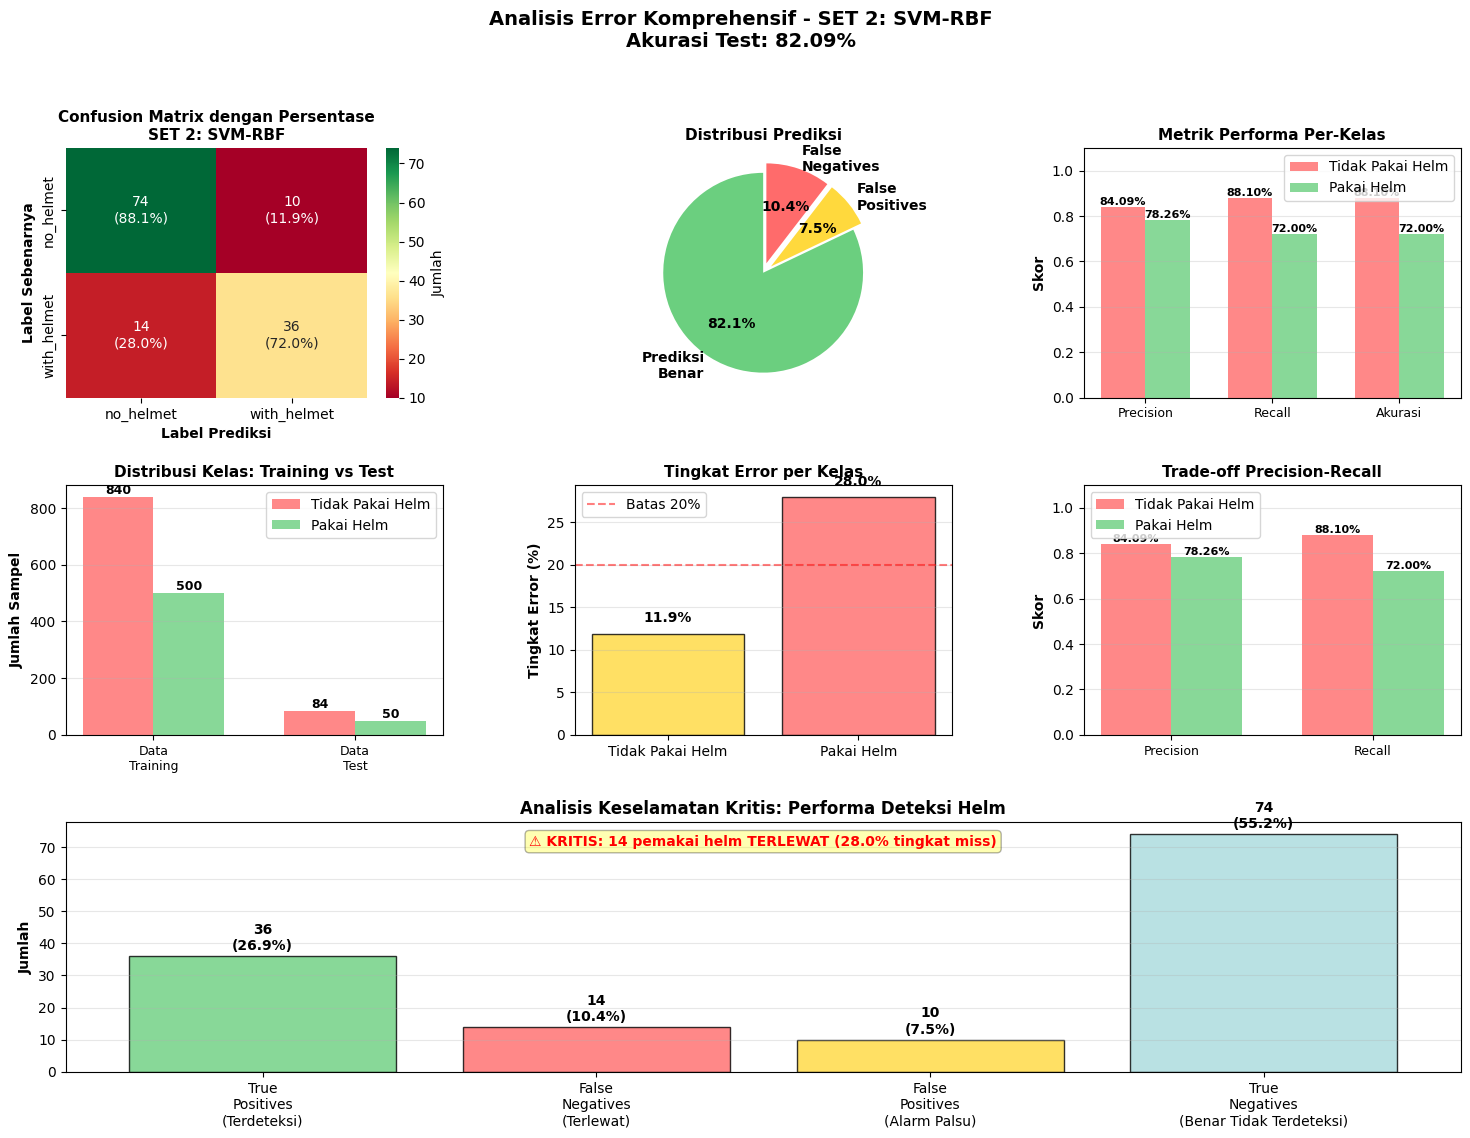

🔎 5. ANALISIS POLA KESALAHAN KLASIFIKASI

📍 Ringkasan Kesalahan Klasifikasi:
   • Total salah klasifikasi: 24 (17.9%)
   • Terklasifikasi benar: 110 (82.1%)

🔴 Analisis False Positives (prediksi PAKAI helm, sebenarnya TIDAK pakai helm):
   • Jumlah: 10
   • Persentase dari test set: 7.5%
   • Dampak: Error berisiko rendah (alarm palsu)

🔴 Analisis False Negatives (prediksi TIDAK pakai helm, sebenarnya PAKAI helm):
   • Jumlah: 14
   • Persentase dari test set: 10.4%
   • Dampak: Error BERISIKO TINGGI (pelanggaran keselamatan terlewat!)
💡 6. REKOMENDASI UNTUK PERBAIKAN

🎯 Berdasarkan Analisis Error:

   ⚠️ TINGKAT FALSE NEGATIVE TINGGI (28.0%):
      1. Tambah data training untuk kelas 'pakai helm'
      2. Terapkan augmentasi data lebih agresif untuk kelas minoritas
      3. Sesuaikan class weights untuk lebih menghukum FN
      4. Pertimbangkan metode ensemble untuk mengurangi miss rate
      5. Tuning threshold: Turunkan threshold prediksi untuk 'pakai helm'

   ⚖️ KETIDAKSEIMBANGAN 

,Metrik,Nilai
0,Total Sampel Test,134
1,Prediksi Benar,110
2,Total Error,24
3,False Positives (FP),10
4,False Negatives (FN),14
5,True Positives (TP),36
6,True Negatives (TN),74
7,Akurasi Keseluruhan,82.09%
8,Tingkat Error,17.91%
9,Precision (Tidak Pakai Helm),84.09%



✅ Ringkasan tersimpan di: /content/drive/MyDrive/jurnal YOLO/Machine Learning/hasil colab/ringkasan_analisis_error.csv


In [44]:
# @title
# Ambil prediksi dari model terbaik
y_true = best_overall['y_test']
y_pred = best_overall['y_pred']


print("📊 1. BREAKDOWN CONFUSION MATRIX")

cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

print(f"\n🎯 Komponen Confusion Matrix:")
print(f"   True Negatives (TN):  {tn:3d} - Prediksi benar 'tidak pakai helm'")
print(f"   False Positives (FP): {fp:3d} - Prediksi 'pakai helm' tapi sebenarnya 'tidak pakai helm' ⚠️")
print(f"   False Negatives (FN): {fn:3d} - Prediksi 'tidak pakai helm' tapi sebenarnya 'pakai helm'!")
print(f"   True Positives (TP):  {tp:3d} - Prediksi benar 'pakai helm'")

# Hitung metrik per kelas
precision_no_helmet = tn / (tn + fn) if (tn + fn) > 0 else 0
recall_no_helmet = tn / (tn + fp) if (tn + fp) > 0 else 0
precision_with_helmet = tp / (tp + fp) if (tp + fp) > 0 else 0
recall_with_helmet = tp / (tp + fn) if (tp + fn) > 0 else 0

print(f"\n📈 Metrik Per-Kelas:")
print(f"\n   TIDAK PAKAI HELM (Kelas 0):")
print(f"      • Total sampel: {tn + fp}")
print(f"      • Terklasifikasi benar: {tn} ({tn/(tn+fp)*100:.1f}%)")
print(f"      • Salah klasifikasi: {fp} ({fp/(tn+fp)*100:.1f}%)")
print(f"      • Precision: {precision_no_helmet:.2%}")
print(f"      • Recall: {recall_no_helmet:.2%}")
print(f"      • Tingkat Error: {fp/(tn+fp)*100:.1f}%")

print(f"\n   PAKAI HELM (Kelas 1):")
print(f"      • Total sampel: {tp + fn}")
print(f"      • Terklasifikasi benar: {tp} ({tp/(tp+fn)*100:.1f}%)")
print(f"      • Salah klasifikasi: {fn} ({fn/(tp+fn)*100:.1f}%)")
print(f"      • Precision: {precision_with_helmet:.2%}")
print(f"      • Recall: {recall_with_helmet:.2%}")
print(f"      • Tingkat Error: {fn/(tp+fn)*100:.1f}%")


print("🔍 2. ANALISIS TIPE ERROR")

total_errors = fp + fn
total_samples = len(y_true)

print(f"\n📉 Statistik Error Keseluruhan:")
print(f"   • Total sampel: {total_samples}")
print(f"   • Total error: {total_errors}")
print(f"   • Tingkat error: {total_errors/total_samples*100:.2f}%")
print(f"   • Akurasi: {(total_samples-total_errors)/total_samples*100:.2f}%")

print(f"\n⚠️ Distribusi Error:")
print(f"   • False Positives: {fp} ({fp/total_errors*100:.1f}% dari total error)")
print(f"     → Model OVER-prediksi 'pakai helm'")
print(f"     → Mengira orang pakai helm padahal TIDAK")
print(f"     → Dampak: Risiko rendah (alarm palsu)")
print(f"\n   • False Negatives: {fn} ({fn/total_errors*100:.1f}% dari total error)")
print(f"     → Model UNDER-prediksi 'pakai helm'")
print(f"     → Melewatkan orang yang SEBENARNYA pakai helm")
print(f"     → Dampak: KRITIS (risiko keselamatan!)")

# Tentukan bias error
if fp > fn:
    print(f"\n🎯 Bias Model: KONSERVATIF (cenderung memprediksi 'pakai helm')")
    print(f"   → Lebih baik untuk aplikasi keselamatan (false negative lebih sedikit)")
elif fn > fp:
    print(f"\n🎯 Bias Model: LIBERAL (cenderung memprediksi 'tidak pakai helm')")
    print(f"   → Berbahaya untuk keselamatan! Lebih banyak false negative = pelanggaran terlewat")
else:
    print(f"\n🎯 Bias Model: SEIMBANG (FP dan FN sama)")


print("⚖️ 3. DAMPAK KETIDAKSEIMBANGAN KELAS")

# Hitung distribusi original dari semua data (gunakan y_train + y_val + y_test atau labels asli)
# Untuk mendapatkan distribusi training yang digunakan, kita ambil dari hasil run_experiment
# Alternatif: hitung dari test set yang tersedia
try:
    # Coba ambil dari labels global jika ada
    unique_all, counts_all = np.unique(labels, return_counts=True)
    class_dist = dict(zip(unique_all.astype(int), counts_all))
except:
    # Jika gagal, estimasi dari test set saja
    unique_all, counts_all = np.unique(y_true, return_counts=True)
    # Estimasi proporsi dari test set (asumsi proporsi sama)
    total_estimated = len(y_true) * 10  # Asumsi test = 10% dari total
    class_dist = {int(k): int(v * 10) for k, v in zip(unique_all, counts_all)}

print(f"\n📊 Distribusi Dataset Awal:")
if 0 in class_dist and 1 in class_dist:
    print(f"   • Tidak pakai helm (0): {class_dist[0]} sampel ({class_dist[0]/sum(class_dist.values())*100:.1f}%)")
    print(f"   • Pakai helm (1): {class_dist[1]} sampel ({class_dist[1]/sum(class_dist.values())*100:.1f}%)")
    print(f"   • Rasio ketidakseimbangan: {class_dist[0]/class_dist[1]:.2f}:1")
else:
    print(f"   ⚠️ Tidak dapat menghitung distribusi dataset awal")
    print(f"   • Menggunakan distribusi test set sebagai referensi")

# Distribusi test set
unique_test, counts_test = np.unique(y_true, return_counts=True)
test_dist = dict(zip(unique_test, counts_test))

print(f"\n📊 Distribusi Test Set:")
print(f"   • Tidak pakai helm (0): {test_dist[0]} sampel ({test_dist[0]/len(y_true)*100:.1f}%)")
print(f"   • Pakai helm (1): {test_dist[1]} sampel ({test_dist[1]/len(y_true)*100:.1f}%)")

# Hitung bias performa
accuracy_no_helmet = tn / (tn + fp)
accuracy_with_helmet = tp / (tp + fn)
performance_gap = abs(accuracy_no_helmet - accuracy_with_helmet)

print(f"\n📈 Perbandingan Performa:")
print(f"   • Akurasi tidak pakai helm: {accuracy_no_helmet:.2%}")
print(f"   • Akurasi pakai helm: {accuracy_with_helmet:.2%}")
print(f"   • Gap performa: {performance_gap:.2%}")

if performance_gap > 0.10:
    print(f"\n⚠️ PERINGATAN: Gap performa signifikan terdeteksi!")
    print(f"   → Model berkinerja lebih baik pada '{CLASS_NAMES[0 if accuracy_no_helmet > accuracy_with_helmet else 1]}'")
    print(f"   → Kemungkinan karena ketidakseimbangan kelas pada data training")
else:
    print(f"\n✅ Performa seimbang antar kelas")


print("📊 4. MEMBUAT VISUALISASI ANALISIS ERROR")

fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.35)

# 4.1 Confusion Matrix dengan Persentase
ax1 = fig.add_subplot(gs[0, 0])
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
annot_labels = np.array([[f'{cm[i,j]}\n({cm_percent[i,j]:.1%})' for j in range(cm.shape[1])] for i in range(cm.shape[0])])
sns.heatmap(cm, annot=annot_labels, fmt='', cmap='RdYlGn',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            ax=ax1, cbar_kws={'label': 'Jumlah'})
ax1.set_title(f'Confusion Matrix dengan Persentase\n{set_names_dict[id(best_overall)]}: {best_overall["algorithm"]}',
              fontweight='bold', fontsize=11)
ax1.set_ylabel('Label Sebenarnya', fontweight='bold')
ax1.set_xlabel('Label Prediksi', fontweight='bold')

# 4.2 Distribusi Tipe Error (Pie Chart)
ax2 = fig.add_subplot(gs[0, 1])
error_types = ['Prediksi\nBenar', 'False\nPositives', 'False\nNegatives']
error_counts = [tn + tp, fp, fn]
colors_pie = ['#6bcf7f', '#ffd93d', '#ff6b6b']
explode = (0, 0.1, 0.1)

ax2.pie(error_counts, labels=error_types, autopct='%1.1f%%', startangle=90,
        colors=colors_pie, explode=explode, textprops={'fontweight': 'bold'})
ax2.set_title('Distribusi Prediksi', fontweight='bold', fontsize=11)

# 4.3 Metrik Performa Per-Kelas
ax3 = fig.add_subplot(gs[0, 2])
metrics_data = {
    'Tidak Pakai Helm': [precision_no_helmet, recall_no_helmet, accuracy_no_helmet],
    'Pakai Helm': [precision_with_helmet, recall_with_helmet, accuracy_with_helmet]
}
x = np.arange(len(['Precision', 'Recall', 'Akurasi']))
width = 0.35

bars1 = ax3.bar(x - width/2, metrics_data['Tidak Pakai Helm'], width, label='Tidak Pakai Helm', color='#ff6b6b', alpha=0.8)
bars2 = ax3.bar(x + width/2, metrics_data['Pakai Helm'], width, label='Pakai Helm', color='#6bcf7f', alpha=0.8)

ax3.set_ylabel('Skor', fontweight='bold')
ax3.set_title('Metrik Performa Per-Kelas', fontweight='bold', fontsize=11)
ax3.set_xticks(x)
ax3.set_xticklabels(['Precision', 'Recall', 'Akurasi'], fontsize=9)
ax3.legend()
ax3.grid(axis='y', alpha=0.3)
ax3.set_ylim([0, 1.1])

# Tambah label nilai pada bar
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2%}', ha='center', va='bottom', fontsize=8, fontweight='bold')

# 4.4 Perbandingan Distribusi Kelas
ax4 = fig.add_subplot(gs[1, 0])
categories = ['Data\nTraining', 'Data\nTest']

# Ambil distribusi dengan aman
if 0 in class_dist and 1 in class_dist:
    no_helmet_counts = [class_dist[0], test_dist.get(0, 0)]
    with_helmet_counts = [class_dist[1], test_dist.get(1, 0)]
else:
    # Jika class_dist tidak tersedia, gunakan test dist saja
    no_helmet_counts = [test_dist.get(0, 0) * 8, test_dist.get(0, 0)]  # Estimasi 80% training
    with_helmet_counts = [test_dist.get(1, 0) * 8, test_dist.get(1, 0)]

x = np.arange(len(categories))
width = 0.35

bars1 = ax4.bar(x - width/2, no_helmet_counts, width, label='Tidak Pakai Helm', color='#ff6b6b', alpha=0.8)
bars2 = ax4.bar(x + width/2, with_helmet_counts, width, label='Pakai Helm', color='#6bcf7f', alpha=0.8)

ax4.set_ylabel('Jumlah Sampel', fontweight='bold')
ax4.set_title('Distribusi Kelas: Training vs Test', fontweight='bold', fontsize=11)
ax4.set_xticks(x)
ax4.set_xticklabels(categories, fontsize=9)
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

# Tambah label nilai
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# 4.5 Tingkat Error per Kelas
ax5 = fig.add_subplot(gs[1, 1])
classes = ['Tidak Pakai Helm', 'Pakai Helm']
error_rates = [fp/(tn+fp)*100, fn/(tp+fn)*100]
colors_err = ['#ffd93d' if e < 20 else '#ff6b6b' for e in error_rates]

bars = ax5.bar(classes, error_rates, color=colors_err, edgecolor='black', alpha=0.8)
ax5.set_ylabel('Tingkat Error (%)', fontweight='bold')
ax5.set_title('Tingkat Error per Kelas', fontweight='bold', fontsize=11)
ax5.axhline(y=20, color='red', linestyle='--', alpha=0.5, label='Batas 20%')
ax5.legend()
ax5.grid(axis='y', alpha=0.3)

for i, (bar, val) in enumerate(zip(bars, error_rates)):
    ax5.text(bar.get_x() + bar.get_width()/2., val + 1,
            f'{val:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 4.6 Trade-off Precision-Recall
ax6 = fig.add_subplot(gs[1, 2])
metrics_comparison = ['Precision', 'Recall']
no_helmet_metrics = [precision_no_helmet, recall_no_helmet]
with_helmet_metrics = [precision_with_helmet, recall_with_helmet]

x = np.arange(len(metrics_comparison))
width = 0.35

bars1 = ax6.bar(x - width/2, no_helmet_metrics, width, label='Tidak Pakai Helm', color='#ff6b6b', alpha=0.8)
bars2 = ax6.bar(x + width/2, with_helmet_metrics, width, label='Pakai Helm', color='#6bcf7f', alpha=0.8)

ax6.set_ylabel('Skor', fontweight='bold')
ax6.set_title('Trade-off Precision-Recall', fontweight='bold', fontsize=11)
ax6.set_xticks(x)
ax6.set_xticklabels(metrics_comparison, fontsize=9)
ax6.legend()
ax6.grid(axis='y', alpha=0.3)
ax6.set_ylim([0, 1.1])

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax6.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2%}', ha='center', va='bottom', fontsize=8, fontweight='bold')

# 4.7 Analisis Keselamatan Kritis
ax7 = fig.add_subplot(gs[2, :])
safety_metrics = ['True\nPositives\n(Terdeteksi)', 'False\nNegatives\n(Terlewat)', 'False\nPositives\n(Alarm Palsu)', 'True\nNegatives\n(Benar Tidak Terdeteksi)']
safety_counts = [tp, fn, fp, tn]
safety_colors = ['#6bcf7f', '#ff6b6b', '#ffd93d', '#a8dadc']

bars = ax7.bar(safety_metrics, safety_counts, color=safety_colors, edgecolor='black', alpha=0.8)
ax7.set_ylabel('Jumlah', fontweight='bold')
ax7.set_title('Analisis Keselamatan Kritis: Performa Deteksi Helm', fontweight='bold', fontsize=12)
ax7.grid(axis='y', alpha=0.3)

# Tambah anotasi
for i, (bar, val) in enumerate(zip(bars, safety_counts)):
    percentage = val / len(y_true) * 100
    ax7.text(bar.get_x() + bar.get_width()/2., val + 1,
            f'{val}\n({percentage:.1f}%)', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Tambah interpretasi keselamatan
safety_text = f"⚠️ KRITIS: {fn} pemakai helm TERLEWAT ({fn/(tp+fn)*100:.1f}% tingkat miss)"
ax7.text(0.5, 0.95, safety_text, transform=ax7.transAxes,
         ha='center', va='top', fontsize=10, fontweight='bold', color='red',
         bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3))

plt.suptitle(f'Analisis Error Komprehensif - {set_names_dict[id(best_overall)]}: {best_overall["algorithm"]}\nAkurasi Test: {best_overall["test_acc"]:.2%}',
             fontsize=14, fontweight='bold', y=0.995)

# Simpan ke Google Drive
drive_save_path = "/content/drive/MyDrive/jurnal YOLO/Machine Learning/hasil colab"
os.makedirs(drive_save_path, exist_ok=True)

save_path_error = os.path.join(drive_save_path, 'analisis_error_detail.png')
plt.savefig(save_path_error, dpi=300, bbox_inches='tight')
print(f"✅ Tersimpan: {save_path_error}")
plt.show()


print("🔎 5. ANALISIS POLA KESALAHAN KLASIFIKASI")
# Cari indeks yang salah klasifikasi
misclassified_indices = np.where(y_true != y_pred)[0]
correct_indices = np.where(y_true == y_pred)[0]

print(f"\n📍 Ringkasan Kesalahan Klasifikasi:")
print(f"   • Total salah klasifikasi: {len(misclassified_indices)} ({len(misclassified_indices)/len(y_true)*100:.1f}%)")
print(f"   • Terklasifikasi benar: {len(correct_indices)} ({len(correct_indices)/len(y_true)*100:.1f}%)")

# Analisis FP dan FN terpisah
fp_indices = np.where((y_true == 0) & (y_pred == 1))[0]
fn_indices = np.where((y_true == 1) & (y_pred == 0))[0]

print(f"\n🔴 Analisis False Positives (prediksi PAKAI helm, sebenarnya TIDAK pakai helm):")
print(f"   • Jumlah: {len(fp_indices)}")
print(f"   • Persentase dari test set: {len(fp_indices)/len(y_true)*100:.1f}%")
print(f"   • Dampak: Error berisiko rendah (alarm palsu)")

print(f"\n🔴 Analisis False Negatives (prediksi TIDAK pakai helm, sebenarnya PAKAI helm):")
print(f"   • Jumlah: {len(fn_indices)}")
print(f"   • Persentase dari test set: {len(fn_indices)/len(y_true)*100:.1f}%")
print(f"   • Dampak: Error BERISIKO TINGGI (pelanggaran keselamatan terlewat!)")


print("💡 6. REKOMENDASI UNTUK PERBAIKAN")
print("\n🎯 Berdasarkan Analisis Error:")

# Rekomendasi berdasarkan false negative rate
fn_rate = fn / (tp + fn)
if fn_rate > 0.20:
    print(f"\n   ⚠️ TINGKAT FALSE NEGATIVE TINGGI ({fn_rate:.1%}):")
    print(f"      1. Tambah data training untuk kelas 'pakai helm'")
    print(f"      2. Terapkan augmentasi data lebih agresif untuk kelas minoritas")
    print(f"      3. Sesuaikan class weights untuk lebih menghukum FN")
    print(f"      4. Pertimbangkan metode ensemble untuk mengurangi miss rate")
    print(f"      5. Tuning threshold: Turunkan threshold prediksi untuk 'pakai helm'")

# Rekomendasi berdasarkan class imbalance
if 0 in class_dist and 1 in class_dist:
    imbalance_ratio = class_dist[0] / class_dist[1]
    if imbalance_ratio > 1.5:
        print(f"\n   ⚖️ KETIDAKSEIMBANGAN KELAS TERDETEKSI (rasio {imbalance_ratio:.2f}:1):")
        print(f"      1. Kumpulkan lebih banyak sampel 'pakai helm'")
        print(f"      2. Terapkan SMOTE atau teknik oversampling lain (sudah diterapkan ✓)")
        print(f"      3. Gunakan class_weight='balanced' pada algoritma (sudah diterapkan ✓)")
        print(f"      4. Pertimbangkan focal loss untuk training")

# Rekomendasi berdasarkan performance gap
if performance_gap > 0.10:
    print(f"\n   📊 GAP PERFORMA TERDETEKSI ({performance_gap:.1%}):")
    print(f"      1. Model bias terhadap kelas mayoritas")
    print(f"      2. Butuh representasi fitur yang lebih baik untuk kelas minoritas")
    print(f"      3. Pertimbangkan stratified sampling yang lebih agresif")

# Rekomendasi feature engineering
print(f"\n   🔧 SARAN FEATURE ENGINEERING:")
print(f"      1. Coba gabungkan multiple feature sets (ensemble)")
print(f"      2. Eksperimen dengan konfigurasi HOG yang lebih dalam")
print(f"      3. Tambah transformasi color-space (HSV, LAB)")
print(f"      4. Sertakan fitur spatial pyramid")
print(f"      5. Coba deep features dari CNN pre-trained")

# Rekomendasi algoritma
if best_overall['algorithm'] == 'SVM-RBF':
    print(f"\n   🤖 TUNING ALGORITMA:")
    print(f"      1. Saat ini: SVM-RBF (pilihan bagus ✓)")
    print(f"      2. Fine-tune parameter C dan gamma via GridSearch")
    print(f"      3. Coba ensemble dari 2-3 algoritma terbaik")
    print(f"      4. Pertimbangkan XGBoost atau LightGBM untuk performa lebih baik")

print(f"\n   📈 PERTIMBANGAN DEPLOYMENT:")
print(f"      1. Set threshold lebih tinggi untuk 'pakai helm' untuk kurangi FN")
print(f"      2. Implementasi confidence-based rejection untuk prediksi tidak pasti")
print(f"      3. Tambah human-in-the-loop untuk kasus borderline")
print(f"      4. Lakukan retraining model berkala dengan data baru")


print("📋 7. RINGKASAN STATISTIK")


summary_data = {
    'Metrik': [
        'Total Sampel Test',
        'Prediksi Benar',
        'Total Error',
        'False Positives (FP)',
        'False Negatives (FN)',
        'True Positives (TP)',
        'True Negatives (TN)',
        'Akurasi Keseluruhan',
        'Tingkat Error',
        'Precision (Tidak Pakai Helm)',
        'Recall (Tidak Pakai Helm)',
        'Precision (Pakai Helm)',
        'Recall (Pakai Helm)',
        'F1-Score (Tidak Pakai Helm)',
        'F1-Score (Pakai Helm)',
        'Rasio Ketidakseimbangan Kelas',
        'Tingkat FN (KRITIS)',
        'Tingkat FP'
    ],
    'Nilai': [
        len(y_true),
        tn + tp,
        fp + fn,
        fp,
        fn,
        tp,
        tn,
        f"{(tn+tp)/len(y_true):.2%}",
        f"{(fp+fn)/len(y_true):.2%}",
        f"{precision_no_helmet:.2%}",
        f"{recall_no_helmet:.2%}",
        f"{precision_with_helmet:.2%}",
        f"{recall_with_helmet:.2%}",
        f"{2*precision_no_helmet*recall_no_helmet/(precision_no_helmet+recall_no_helmet):.2%}" if (precision_no_helmet+recall_no_helmet) > 0 else "0.00%",
        f"{2*precision_with_helmet*recall_with_helmet/(precision_with_helmet+recall_with_helmet):.2%}" if (precision_with_helmet+recall_with_helmet) > 0 else "0.00%",
        f"{class_dist[0]/class_dist[1]:.2f}:1" if (0 in class_dist and 1 in class_dist) else "N/A",
        f"{fn/(tp+fn):.2%}",
        f"{fp/(tn+fp):.2%}"
    ]
}

df_summary = pd.DataFrame(summary_data)
print("\n")
display(df_summary)

# Simpan ringkasan ke CSV
csv_path = os.path.join(drive_save_path, 'ringkasan_analisis_error.csv')
df_summary.to_csv(csv_path, index=False)
print(f"\n✅ Ringkasan tersimpan di: {csv_path}")


## Simpen Best Model

>opsional sih, sp tau kepake

In [45]:
# Determine which feature extractor to use
feature_extractors = {
    id(best_set1): extract_set1_features,
    id(best_set2): extract_set2_features,
    id(best_set3): extract_set3_features
}

# Define Google Drive save path
drive_save_path = "/content/drive/MyDrive/jurnal YOLO/Machine Learning/hasil colab"
os.makedirs(drive_save_path, exist_ok=True)

with open(os.path.join(drive_save_path, 'best_overall_model.pkl'), 'wb') as f:
    pickle.dump({
        'model': best_overall['model'],
        'scaler': best_overall['scaler'],
        'pca': best_overall['pca'],
        'feature_set': set_names_dict[id(best_overall)],
        'algorithm': best_overall['algorithm'],
        'feature_extractor': feature_extractors[id(best_overall)],
        'class_names': CLASS_NAMES,
        'test_acc': best_overall['test_acc'],
        'val_acc': best_overall['val_acc'],
        'train_acc': best_overall['train_acc'],
        'overfitting': best_overall['overfitting']
    }, f)

print(f"✅ Overall best model saved: {os.path.join(drive_save_path, 'best_overall_model.pkl')}")

✅ Overall best model saved: /content/drive/MyDrive/jurnal YOLO/Machine Learning/hasil colab/best_overall_model.pkl


In [46]:
print("🔧 Quick fix: Re-loading full labels dataset...")

_, labels = load_cropped_data(dataset.location, augmentation_seed=42)

print(f"✅ Re-loaded successfully!")
print(f"   Total labels: {len(labels)}")
print(f"   Distribution: {np.bincount(labels).tolist()}")
print(f"   Match with images: {len(labels) == len(cropped_images)}")

# Verify
assert len(labels) == len(cropped_images), "Still mismatch!"
print("\n✅ Ready for Part 2!")

🔧 Quick fix: Re-loading full labels dataset...
📦 Loading and cropping bboxes
✅ Processed: 1334 bboxes
   Distribution: [832, 502] (0=no_helmet, 1=with_helmet)
   🎲 Used augmentation seeds: 42 to 1375
✅ Re-loaded successfully!
   Total labels: 1334
   Distribution: [832, 502]
   Match with images: True

✅ Ready for Part 2!


# PART 2: CNN & LORA

In [62]:
# @title
print("\n🔍 Validating variables from Part 1...")

required_vars = {
    'cropped_images': 'Cropped images dataset',
    'CLASS_NAMES': 'Class names list',
    'best_set1': 'Best model from SET 1',
    'best_set2': 'Best model from SET 2',
    'best_set3': 'Best model from SET 3',
    'drive_save_path': 'Google Drive save path'
}

missing = []
for var_name, description in required_vars.items():
    if var_name not in globals():
        missing.append(f"❌ {var_name} ({description})")
    else:
        print(f"✅ {var_name} - OK")

if missing:
    print("\n⚠️ ERROR: Missing variables from Part 1:")
    for m in missing:
        print(f"   {m}")
    print("\n👉 Please run Part 1 (with random seed) first!")
    raise RuntimeError("Part 1 not completed")

print(f"\n🔧 Retrieving FULL labels array...")
print(f"   Total images to match: {len(cropped_images)}")

y_labels_part1 = None

# BEST METHOD: Re-load from load_cropped_data
# Ini guaranteed dapat full dataset (1334 samples)
if 'dataset' in globals() and hasattr(dataset, 'location'):
    print(f"   🔄 Re-loading labels from dataset at {dataset.location}...")
    try:
        _, y_labels_part1 = load_cropped_data(dataset.location, augmentation_seed=42)
        print(f"   ✅ Successfully re-loaded {len(y_labels_part1)} labels")
        print(f"   📊 Label distribution: {np.bincount(y_labels_part1).tolist()}")
    except Exception as e:
        print(f"   ❌ Failed to re-load: {e}")
        y_labels_part1 = None

# FALLBACK: Try to find backup variable
if y_labels_part1 is None:
    print(f"   ⚠️ Primary method failed, trying fallback methods...")

    # Check for backup variables
    for backup_name in ['labels_backup', 'y_labels', 'original_labels', 'all_labels']:
        if backup_name in globals():
            try:
                temp_labels = globals()[backup_name]
                if isinstance(temp_labels, np.ndarray) and len(temp_labels) == len(cropped_images):
                    y_labels_part1 = temp_labels
                    print(f"   ✅ Found backup in '{backup_name}': {len(y_labels_part1)} labels")
                    break
            except:
                continue

# LAST RESORT: Cannot proceed
if y_labels_part1 is None:
    error_msg = f"""
    ❌ CRITICAL ERROR: Cannot retrieve labels!

    Current state:
    - cropped_images: {len(cropped_images)} samples
    - labels needed: {len(cropped_images)} samples
    - best_set1['y_test']: {len(best_set1['y_test'])} samples (only test set)

    SOLUTION OPTIONS:

    Option 1 (RECOMMENDED): Re-run Part 1 with protection
    Add this at END of Part 1 before running Part 2:

        # Protect labels
        labels_for_part2 = labels.copy()
        print(f"Protected labels_for_part2: {{len(labels_for_part2)}}")

    Then modify Part 2 validation to use 'labels_for_part2'

    Option 2: Manually re-load
    Run this cell before Part 2:

        _, labels_for_part2 = load_cropped_data(dataset.location, augmentation_seed=42)
        print(f"Reloaded {{len(labels_for_part2)}} labels")

    Option 3: Re-run entire notebook from beginning
    """
    raise RuntimeError(error_msg)

# Validate
assert y_labels_part1 is not None, "Failed to retrieve labels!"
assert len(y_labels_part1) == len(cropped_images), f"Mismatch: labels={len(y_labels_part1)}, images={len(cropped_images)}"

print(f"\n✅ All variables ready!")
print(f"   Total images: {len(cropped_images)}")
print(f"   Total labels: {len(y_labels_part1)}")
print(f"   Label distribution: {np.bincount(y_labels_part1).tolist()}")
print(f"   Classes: {CLASS_NAMES}")

# Use y_labels_part1 for the rest of the code
labels = y_labels_part1



🔍 Validating variables from Part 1...
✅ cropped_images - OK
✅ CLASS_NAMES - OK
✅ best_set1 - OK
✅ best_set2 - OK
✅ best_set3 - OK
✅ drive_save_path - OK

🔧 Retrieving FULL labels array...
   Total images to match: 1334
   🔄 Re-loading labels from dataset at /content/h3Lm-40L0-Oid-XD-5...
📦 Loading and cropping bboxes
✅ Processed: 1334 bboxes
   Distribution: [832, 502] (0=no_helmet, 1=with_helmet)
   🎲 Used augmentation seeds: 42 to 1375
   ✅ Successfully re-loaded 1334 labels
   📊 Label distribution: [832, 502]

✅ All variables ready!
   Total images: 1334
   Total labels: 1334
   Label distribution: [832, 502]
   Classes: ['no_helmet', 'with_helmet']


## INSTALL & IMPORT LIBRARIES TAMBAHAN

In [63]:
# @title
print("\n📦 Installing additional libraries...")
!pip install -q tensorflow>=2.13.0

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0, ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight

def set_tensorflow_seeds(seed=42):
    import random
    import numpy as np
    import tensorflow as tf
    import os

    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

    # Environment variables for deterministic operations
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

    # Configure TensorFlow for deterministic behavior
    tf.config.experimental.enable_op_determinism()

    print(f"\n🎲 All TensorFlow seeds set to: {seed}")
    print("   ✓ Python random")
    print("   ✓ NumPy")
    print("   ✓ TensorFlow")
    print("   ✓ CUDA (if available)")
    print("   ✓ Deterministic operations enabled")
    print("   ✓ Results will be FULLY reproducible!")

# Set seeds
set_tensorflow_seeds(42)

print(f"\n✅ TensorFlow version: {tf.__version__}")
gpu_devices = tf.config.list_physical_devices('GPU')
print(f"✅ GPU available: {len(gpu_devices) > 0}")
if gpu_devices:
    print(f"   GPU: {gpu_devices[0].name}")


📦 Installing additional libraries...

🎲 All TensorFlow seeds set to: 42
   ✓ Python random
   ✓ NumPy
   ✓ TensorFlow
   ✓ CUDA (if available)
   ✓ Deterministic operations enabled
   ✓ Results will be FULLY reproducible!

✅ TensorFlow version: 2.19.0
✅ GPU available: True
   GPU: /physical_device:GPU:0


## PREPARE DATA UNTUK DEEP LEARNING

In [64]:
X_images = np.array([cv2.resize(img, (128, 128)) for img in cropped_images])
X_images = X_images.astype('float32') / 255.0  # Normalize to [0, 1]
y_labels = np.array(labels)

print(f"\n📐 Data shape:")
print(f"   X_images: {X_images.shape}")  # (N, 128, 128, 3)
print(f"   y_labels: {y_labels.shape}")  # (N,)
print(f"   Label distribution: {np.bincount(y_labels)}")

# Validasi
assert X_images.shape[0] == y_labels.shape[0], f"Mismatch! Images: {X_images.shape[0]}, Labels: {y_labels.shape[0]}"
assert X_images.shape[0] > 1000, f"Too few samples: {X_images.shape[0]}"

print(f"\n✅ Data validation passed!")

# Split data (SEEDED - consistent with Part 1)
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
    X_images, y_labels, test_size=0.2, random_state=42, stratify=y_labels
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"\n✅ Data split (with seed=42):")
print(f"   Train: {len(X_train)} samples - {np.bincount(y_train)}")
print(f"   Val:   {len(X_val)} samples - {np.bincount(y_val)}")
print(f"   Test:  {len(X_test)} samples - {np.bincount(y_test)}")

# Hitung class weights
class_weights_array = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: class_weights_array[i] for i in range(len(class_weights_array))}
print(f"\n⚖️ Class weights: {class_weights}")


📐 Data shape:
   X_images: (1334, 128, 128, 3)
   y_labels: (1334,)
   Label distribution: [832 502]

✅ Data validation passed!

✅ Data split (with seed=42):
   Train: 1067 samples - [665 402]
   Val:   133 samples - [83 50]
   Test:  134 samples - [84 50]

⚖️ Class weights: {0: np.float64(0.8022556390977443), 1: np.float64(1.3271144278606966)}


## DATA AUGMENTATION

In [65]:

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

print("✅ Data augmentation configured ")

✅ Data augmentation configured 


## BUILD MODEL FUNCTION

In [66]:
# @title
def create_transfer_learning_model_seeded(base_model_name='mobilenetv2', input_shape=(128, 128, 3), num_classes=2):

    print(f"\n🔨 Building {base_model_name.upper()} model ")

    # Load pre-trained model
    if base_model_name.lower() == 'mobilenetv2':
        base_model = MobileNetV2(
            input_shape=input_shape,
            include_top=False,
            weights='imagenet'
        )
    else:
        raise ValueError(f"Unknown model: {base_model_name}")

    # Freeze base model (LoRA strategy)
    base_model.trainable = False

    print(f"   ✅ Base model loaded: {base_model_name}")
    print(f"   📊 Total base parameters: {base_model.count_params():,}")
    print(f"   🔒 Base model frozen (LoRA strategy)")

    # Build complete model
    model = keras.Sequential([
        keras.Input(shape=input_shape),
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu',
                    kernel_initializer=keras.initializers.GlorotUniform(seed=42),
                    name='adapter_dense_1'),
        layers.Dense(num_classes, activation='softmax',
                    kernel_initializer=keras.initializers.GlorotUniform(seed=42),
                    name='output')
    ], name=f'{base_model_name}_transfer_seeded')

    # Count parameters
    trainable_params = sum([tf.size(v).numpy() for v in model.trainable_variables])
    total_params = sum([tf.size(v).numpy() for v in model.variables])

    print(f"   📊 Total parameters: {total_params:,}")
    print(f"   🎯 Trainable parameters: {trainable_params:,} ({trainable_params/total_params*100:.2f}%)")
    print(f"   🎲 Weight initialization: Seeded (GlorotUniform with seed=42)")

    return model

## CREATE & COMPILE MODEL

In [67]:

tf.config.optimizer.set_jit(False)

model_mobilenet = create_transfer_learning_model_seeded('mobilenetv2', input_shape=(128, 128, 3), num_classes=2)

model_mobilenet.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
    run_eagerly=False
)

print("\n✅ Model compiled successfully!")
print("\n📋 Model summary:")
model_mobilenet.summary()


🔨 Building MOBILENETV2 model 
   ✅ Base model loaded: mobilenetv2
   📊 Total base parameters: 2,257,984
   🔒 Base model frozen (LoRA strategy)
   📊 Total parameters: 2,422,210
   🎯 Trainable parameters: 164,226 (6.78%)
   🎲 Weight initialization: Seeded (GlorotUniform with seed=42)

✅ Model compiled successfully!

📋 Model summary:


Model: "mobilenetv2_transfer_seeded"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ adapter_dense_1 (Dense)         │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,210 (9.24 MB)

 Trainable params: 164,226 (641.51 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## SETUP CALLBACKS

In [68]:
# Early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Reduce learning rate
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

# Save best model
checkpoint = ModelCheckpoint(
    'best_model_mobilenet_lora_seeded.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

callbacks = [early_stop, reduce_lr, checkpoint]

print("✅ Callbacks configured")

✅ Callbacks configured


## TRAINING MODEL

In [69]:
print("\n⏳ Starting training...")
print(f"   Dataset: {len(X_train)} training samples")
print(f"   Batch size: 32")
print(f"   Max epochs: 50")
print(f"   Random seed: 42")

import time
start_time = time.time()

# Try normal training first
try:
    history = model_mobilenet.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=32,
        class_weight=class_weights,
        callbacks=callbacks,
        verbose=1,
        shuffle=True  # Shuffle with fixed seed
    )
except Exception as e:
    print(f"\n⚠️ Error with normal mode: {e}")
    print("🔄 Retrying with eager execution...")

    # Rebuild with eager mode
    model_mobilenet = create_transfer_learning_model_seeded('mobilenetv2', input_shape=(128, 128, 3), num_classes=2)
    model_mobilenet.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'],
        run_eagerly=True
    )

    history = model_mobilenet.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=32,
        class_weight=class_weights,
        callbacks=callbacks,
        verbose=1,
        shuffle=True
    )

training_time = time.time() - start_time

print("\n✅ Training completed!")
print(f"   Total time: {training_time/60:.2f} minutes")
print(f"   Final epoch: {len(history.history['loss'])}")
print(f"   Best val_accuracy: {max(history.history['val_accuracy']):.4f}")


⏳ Starting training...
   Dataset: 1067 training samples
   Batch size: 32
   Max epochs: 50
   Random seed: 42
Epoch 1/50
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.7314 - loss: 0.6746
Epoch 1: val_accuracy improved from -inf to 0.84211, saving model to best_model_mobilenet_lora_seeded.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 17s 256ms/step - accuracy: 0.7334 - loss: 0.6677 - val_accuracy: 0.8421 - val_loss: 0.4388 - learning_rate: 0.0010
Epoch 2/50
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8768 - loss: 0.3080
Epoch 2: val_accuracy improved from 0.84211 to 0.86466, saving model to best_model_mobilenet_lora_seeded.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.8772 - loss: 0.3069 - val_accuracy: 0.8647 - val_loss: 0.3487 - learning_rate: 0.0010
Epoch 3/50
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9285 - loss: 0.1976
Epoch 3: val_accuracy improved from 0.86466 to 0.87970, saving model to best_model_mobilenet_lora_seeded.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.9288 - loss: 0.1973 - val_accuracy: 0.8797 - val_loss: 0.3394 - learning_rate: 0.0010
Epoch 4/50
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9677 - loss: 0.1188
Epoch 4: val_accuracy did not improve from 0.87970
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.9675 - loss: 0.1193 - val_accuracy: 0.8496 - val_loss: 0.3568 - learning_rate: 0.0010
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9750 - loss: 0.0907
Epoch 5: val_accuracy did not improve from 0.87970
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9749 - loss: 0.0911 - val_accuracy: 0.8647 - val_loss: 0.5093 - learning_rate: 0.0010
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9763 - loss: 0.0857
Epoch 6: val_accuracy did not improve from 0.87970
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.9765 - loss: 0.0856 - val_accuracy: 0.8571 - val_loss: 0.6427 - learning_rate: 0.0010
Epoch 7/50
32/34 ━━━━━━━━━━━━━━━

## EVALUATE MODEL

In [70]:
# @title
# Load best model
model_mobilenet = keras.models.load_model('best_model_mobilenet_lora_seeded.h5')

# Evaluate on test set
test_loss, test_acc = model_mobilenet.evaluate(X_test, y_test, verbose=0)

# Get predictions
y_pred_probs = model_mobilenet.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# Calculate metrics manually
from sklearn.metrics import precision_score, recall_score, f1_score

test_precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
test_recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
test_f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print(f"\n📈 Test Set Performance:")
print(f"   Loss:      {test_loss:.4f}")
print(f"   Accuracy:  {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"   Precision: {test_precision:.4f}")
print(f"   Recall:    {test_recall:.4f}")
print(f"   F1-Score:  {test_f1:.4f}")

# Confusion matrix
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_pred)
print(f"\n📊 Confusion Matrix:")
print(cm)

# Detailed metrics
tn, fp, fn, tp = cm.ravel()
print(f"\n🎯 Detailed Metrics:")
print(f"   True Negatives (no_helmet correct):  {tn}")
print(f"   False Positives (predict with_helmet, actually no_helmet): {fp}")
print(f"   False Negatives (predict no_helmet, actually with_helmet): {fn} ⚠️")
print(f"   True Positives (with_helmet correct): {tp}")

# Per-class metrics
precision_no_helmet = tn / (tn + fn) if (tn + fn) > 0 else 0
recall_no_helmet = tn / (tn + fp) if (tn + fp) > 0 else 0
precision_with_helmet = tp / (tp + fp) if (tp + fp) > 0 else 0
recall_with_helmet = tp / (tp + fn) if (tp + fn) > 0 else 0

print(f"\n📊 Per-Class Metrics:")
print(f"   No Helmet:")
print(f"      Precision: {precision_no_helmet:.4f}")
print(f"      Recall:    {recall_no_helmet:.4f}")
print(f"   With Helmet:")
print(f"      Precision: {precision_with_helmet:.4f}")
print(f"      Recall:    {recall_with_helmet:.4f}")

print(f"\n📋 Classification Report:")
print(classification_report(y_test, y_pred, target_names=CLASS_NAMES, zero_division=0))




📈 Test Set Performance:
   Loss:      0.4069
   Accuracy:  0.8582 (85.82%)
   Precision: 0.8584
   Recall:    0.8582
   F1-Score:  0.8557

📊 Confusion Matrix:
[[78  6]
 [13 37]]

🎯 Detailed Metrics:
   True Negatives (no_helmet correct):  78
   False Positives (predict with_helmet, actually no_helmet): 6
   False Negatives (predict no_helmet, actually with_helmet): 13 ⚠️
   True Positives (with_helmet correct): 37

📊 Per-Class Metrics:
   No Helmet:
      Precision: 0.8571
      Recall:    0.9286
   With Helmet:
      Precision: 0.8605
      Recall:    0.7400

📋 Classification Report:
              precision    recall  f1-score   support

   no_helmet       0.86      0.93      0.89        84
 with_helmet       0.86      0.74      0.80        50

    accuracy                           0.86       134
   macro avg       0.86      0.83      0.84       134
weighted avg       0.86      0.86      0.86       134



## VISUALIZE TRAINING HISTORY

✅ Saved: deep_learning_training_history_seeded.png


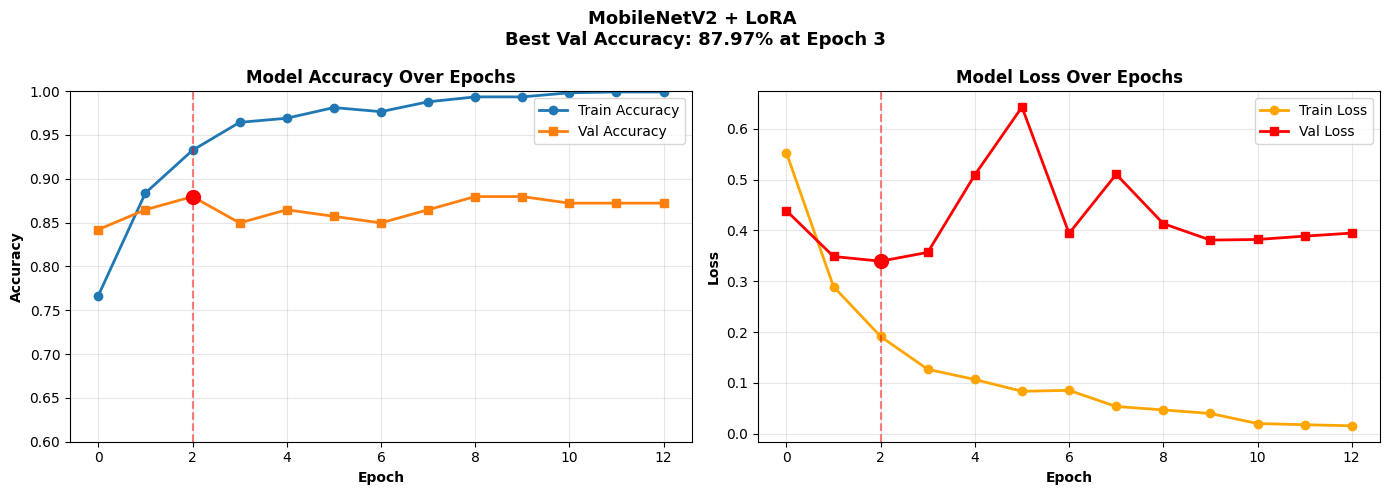


📊 Training Summary:
   Total epochs trained: 13
   Best epoch: 3
   Best validation accuracy: 0.8797 (87.97%)
   Final training accuracy: 0.9991
   Training time: 0.65 minutes
   Overfitting gap: 11.94%


In [71]:
# @title
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Accuracy
axes[0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2, marker='o')
axes[0].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2, marker='s')
axes[0].set_title('Model Accuracy Over Epochs', fontweight='bold', fontsize=12)
axes[0].set_xlabel('Epoch', fontweight='bold')
axes[0].set_ylabel('Accuracy', fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3)
axes[0].set_ylim([0.6, 1.0])

# Highlight best epoch
best_epoch = np.argmax(history.history['val_accuracy'])
best_val_acc = max(history.history['val_accuracy'])
axes[0].axvline(x=best_epoch, color='red', linestyle='--', alpha=0.5, label=f'Best Epoch: {best_epoch+1}')
axes[0].scatter(best_epoch, best_val_acc, color='red', s=100, zorder=5)

# Plot 2: Loss
axes[1].plot(history.history['loss'], label='Train Loss', linewidth=2, marker='o', color='orange')
axes[1].plot(history.history['val_loss'], label='Val Loss', linewidth=2, marker='s', color='red')
axes[1].set_title('Model Loss Over Epochs', fontweight='bold', fontsize=12)
axes[1].set_xlabel('Epoch', fontweight='bold')
axes[1].set_ylabel('Loss', fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3)

# Highlight best epoch
axes[1].axvline(x=best_epoch, color='red', linestyle='--', alpha=0.5)
axes[1].scatter(best_epoch, history.history['val_loss'][best_epoch], color='red', s=100, zorder=5)

plt.suptitle('MobileNetV2 + LoRA \nBest Val Accuracy: {:.2%} at Epoch {}'.format(best_val_acc, best_epoch+1),
             fontsize=13, fontweight='bold')
plt.tight_layout()

# Save
plt.savefig(os.path.join(drive_save_path, 'deep_learning_training_history_seeded.png'), dpi=300, bbox_inches='tight')
print("✅ Saved: deep_learning_training_history_seeded.png")
plt.show()

# Print summary
print(f"\n📊 Training Summary:")
print(f"   Total epochs trained: {len(history.history['loss'])}")
print(f"   Best epoch: {best_epoch + 1}")
print(f"   Best validation accuracy: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")
print(f"   Final training accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"   Training time: {training_time/60:.2f} minutes")
print(f"   Overfitting gap: {(history.history['accuracy'][-1] - best_val_acc)*100:.2f}%")


## VISUALIZE CONFUSION MATRIX

✅ Saved: deep_learning_confusion_matrix_seeded.png


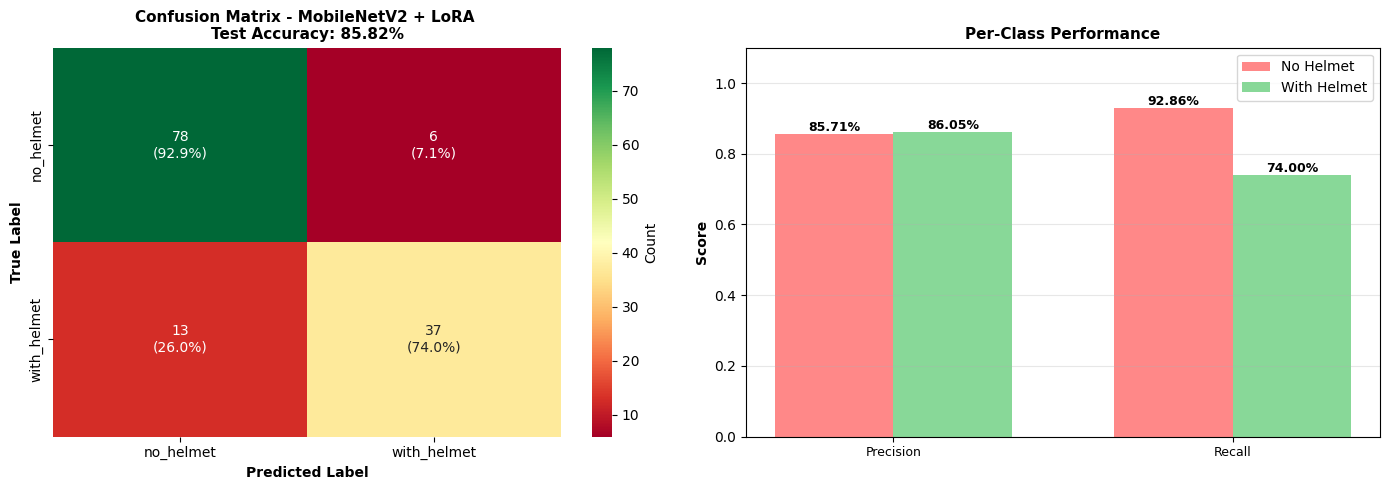

In [72]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Enhanced confusion matrix
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
annot_labels = np.array([[f'{cm[i,j]}\n({cm_percent[i,j]:.1%})'
                          for j in range(cm.shape[1])]
                         for i in range(cm.shape[0])])

sns.heatmap(cm, annot=annot_labels, fmt='', cmap='RdYlGn',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_title(f'Confusion Matrix - MobileNetV2 + LoRA \nTest Accuracy: {test_acc:.2%}',
                  fontweight='bold', fontsize=11)
axes[0].set_ylabel('True Label', fontweight='bold')
axes[0].set_xlabel('Predicted Label', fontweight='bold')

# Per-class metrics
metrics_data = {
    'No Helmet': [precision_no_helmet, recall_no_helmet],
    'With Helmet': [precision_with_helmet, recall_with_helmet]
}

x = np.arange(2)
width = 0.35

bars1 = axes[1].bar(x - width/2, metrics_data['No Helmet'], width,
                    label='No Helmet', color='#ff6b6b', alpha=0.8)
bars2 = axes[1].bar(x + width/2, metrics_data['With Helmet'], width,
                    label='With Helmet', color='#6bcf7f', alpha=0.8)

axes[1].set_ylabel('Score', fontweight='bold')
axes[1].set_title('Per-Class Performance', fontweight='bold', fontsize=11)
axes[1].set_xticks(x)
axes[1].set_xticklabels(['Precision', 'Recall'], fontsize=9)
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_ylim([0, 1.1])

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2%}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(drive_save_path, 'deep_learning_confusion_matrix_seeded.png'), dpi=300, bbox_inches='tight')
print("✅ Saved: deep_learning_confusion_matrix_seeded.png")
plt.show()

## COMPARISON WITH TRADITIONAL ML

In [73]:
# Results from Traditional ML
traditional_ml_results = {
    'SET 1 + SVM-RBF': {
        'accuracy': best_set1['test_acc'],
        'precision': best_set1.get('precision', 0),
        'recall': best_set1.get('recall', 0)
    },
    'SET 2 + SVM-RBF': {
        'accuracy': best_set2['test_acc'],
        'precision': best_set2.get('precision', 0),
        'recall': best_set2.get('recall', 0)
    },
    'SET 3 + SVM-RBF': {
        'accuracy': best_set3['test_acc'],
        'precision': best_set3.get('precision', 0),
        'recall': best_set3.get('recall', 0)
    }
}

# Deep Learning result
dl_result = {
    'accuracy': test_acc,
    'precision': test_precision,
    'recall': test_recall
}

print(f"\n📊 DETAILED COMPARISON :")

print(f"{'Method':<40} {'Accuracy':>10} {'Precision':>10} {'Recall':>10}")


print(f"{'KLASIK ML (PART 1):':<40}")
for method, metrics in traditional_ml_results.items():
    acc = f"{metrics['accuracy']:.2%}" if isinstance(metrics['accuracy'], float) else metrics['accuracy']
    prec = f"{metrics['precision']:.2%}" if isinstance(metrics['precision'], float) else '-'
    rec = f"{metrics['recall']:.2%}" if isinstance(metrics['recall'], float) else '-'
    print(f"  {method:<38} {acc:>10} {prec:>10} {rec:>10}")

print(f"{'='*80}")
print(f"{'CNN & LORA (PART 2):':<40}")
print(f"  {'MobileNetV2 + LoRA':<38} {dl_result['accuracy']:>9.2%} {dl_result['precision']:>9.2%} {dl_result['recall']:>9.2%}")
print(f"{'='*80}")


📊 DETAILED COMPARISON :
Method                                     Accuracy  Precision     Recall
KLASIK ML (PART 1):                     
  SET 1 + SVM-RBF                            78.36%     78.28%     78.36%
  SET 2 + SVM-RBF                            82.09%     81.92%     82.09%
  SET 3 + SVM-RBF                            76.87%     76.78%     76.87%
CNN & LORA (PART 2):                    
  MobileNetV2 + LoRA                        85.82%    85.84%    85.82%


## SAVE MODELS & SUMMARY

In [74]:
# @title
# Save model to Google Drive
model_save_path = os.path.join(drive_save_path, 'mobilenetv2_lora_helmet_detection_seeded.h5')
model_mobilenet.save(model_save_path)
print(f"✅ Model saved: {model_save_path}")

# Get best Traditional ML
best_traditional_acc = max([
    best_set1['test_acc'],
    best_set2['test_acc'],
    best_set3['test_acc']
])

# Find which set is best
if best_set1['test_acc'] == best_traditional_acc:
    best_trad_name = "SET 1 + SVM-RBF"
elif best_set2['test_acc'] == best_traditional_acc:
    best_trad_name = "SET 2 + SVM-RBF"
else:
    best_trad_name = "SET 3 + SVM-RBF"

# Calculate improvement
improvement = (test_acc - best_traditional_acc) / best_traditional_acc * 100

# Create final summary
summary_data = {
    'Method': [
        'Traditional ML - SET 1',
        'Traditional ML - SET 2',
        'Traditional ML - SET 3',
        'Deep Learning - MobileNetV2 + LoRA'
    ],
    'Algorithm': [
        'SVM-RBF + Hist+HOG+LBP',
        'SVM-RBF + ColorMoments+HOG+GLCM',
        'SVM-RBF + Edge+HOG+ColorHist',
        'MobileNetV2 Pre-trained + LoRA Fine-tuning'
    ],
    'Test Accuracy': [
        f"{best_set1['test_acc']:.6f}",
        f"{best_set2['test_acc']:.6f}",
        f"{best_set3['test_acc']:.6f}",
        f"{test_acc:.6f}"
    ],
    'Precision': [
        f"{best_set1.get('precision', 0):.6f}",
        f"{best_set2.get('precision', 0):.6f}",
        f"{best_set3.get('precision', 0):.6f}",
        f"{test_precision:.6f}"
    ],
    'Recall': [
        f"{best_set1.get('recall', 0):.6f}",
        f"{best_set2.get('recall', 0):.6f}",
        f"{best_set3.get('recall', 0):.6f}",
        f"{test_recall:.6f}"
    ],
    'Approach': [
        'Feature Engineering',
        'Feature Engineering',
        'Feature Engineering',
        'Deep Learning'
    ],
    'Reproducible': [
        'Yes (Seed=42)',
        'Yes (Seed=42)',
        'Yes (Seed=42)',
        'Yes (Seed=42)'
    ]
}

df_summary = pd.DataFrame(summary_data)
csv_path = os.path.join(drive_save_path, 'final_summary_all_methods_seeded.csv')
df_summary.to_csv(csv_path, index=False)
print(f"✅ Summary saved: {csv_path}")

print("\n")
display(df_summary)

✅ Model saved: /content/drive/MyDrive/jurnal YOLO/Machine Learning/hasil colab/mobilenetv2_lora_helmet_detection_seeded.h5
✅ Summary saved: /content/drive/MyDrive/jurnal YOLO/Machine Learning/hasil colab/final_summary_all_methods_seeded.csv




,Method,Algorithm,Test Accuracy,Precision,Recall,Approach,Reproducible
0,Traditional ML - SET 1,SVM-RBF + Hist+HOG+LBP,0.783582,0.782767,0.783582,Feature Engineering,Yes (Seed=42)
1,Traditional ML - SET 2,SVM-RBF + ColorMoments+HOG+GLCM,0.820896,0.819155,0.820896,Feature Engineering,Yes (Seed=42)
2,Traditional ML - SET 3,SVM-RBF + Edge+HOG+ColorHist,0.768657,0.767777,0.768657,Feature Engineering,Yes (Seed=42)
3,Deep Learning - MobileNetV2 + LoRA,MobileNetV2 Pre-trained + LoRA Fine-tuning,0.858209,0.858383,0.858209,Deep Learning,Yes (Seed=42)


# test model nyoba doang

📚 TAHAP 1: INSTALL & IMPORT LIBRARIES
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 67.1 MB/s eta 0:00:00
✅ Libraries imported successfully!

📥 TAHAP 2: LOAD DATASET DARI ROBOFLOW
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to h3Lm-40L0-Oid-XD-5 in yolov11:: 100%|██████████| 2732/2732 [00:00<00:00, 8493.86it/s]



✅ Dataset downloaded!
📁 Location: /content/h3Lm-40L0-Oid-XD-5
🎯 Target Classes: ['no_helmet', 'with_helmet']

🔧 TAHAP 3: PREPROCESSING & AUGMENTASI
✅ Preprocessing pipeline created:
   • Resize: 128x128
   • Gaussian Blur (noise reduction)
   • Horizontal Flip
   • Rotation ±15°
   • Brightness/Contrast adjustment
   • HSV color shift

🛠️ TAHAP 4: HELPER FUNCTIONS
✅ Helper functions defined!

✂️ TAHAP 5: CROP BBOXES (MULTIPLE LABELS)
📦 Loading and cropping bboxes...
✅ Processed: 1334 bboxes
   Distribution: [832, 502] (0=no_helmet, 1=with_helmet)

✅ Total cropped bboxes: 1334

🔬 SET 1: HISTOGRAM + HOG + LBP
📊 Extracting features...
✅ Features extracted: (1334, 8222)
   • Histogram: 96 features (32 bins × 3 channels)
   • HOG: ~8100 features
   • LBP: ~26 features

🧪 RUNNING EXPERIMENTS: SET 1: Histogram+HOG+LBP
📊 Data Split: Train=1067, Val=133, Test=134
   Train distribution: [665, 402]
⚖️ SMOTE applied: 1067 → 1330
📉 PCA: 8222 → 738 features (95% variance)

  🔹 Training SVM-RBF...
 

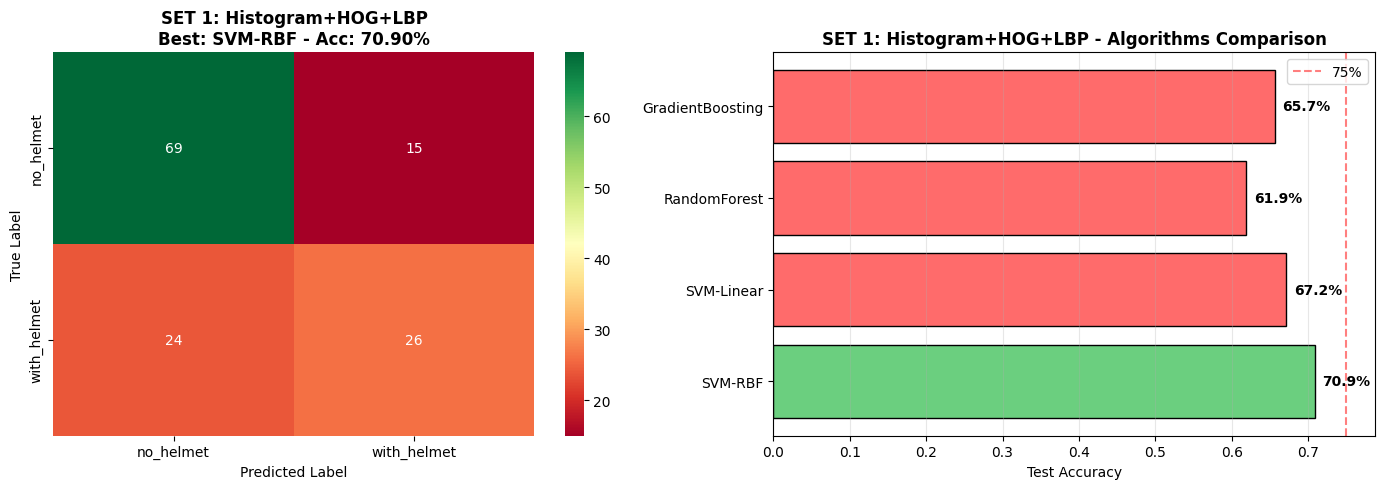


📋 Classification Report - Best Model (SVM-RBF):
              precision    recall  f1-score   support

   no_helmet       0.74      0.82      0.78        84
 with_helmet       0.63      0.52      0.57        50

    accuracy                           0.71       134
   macro avg       0.69      0.67      0.68       134
weighted avg       0.70      0.71      0.70       134


🔬 SET 2: COLOR MOMENTS + HOG + GLCM
📊 Extracting features...
✅ Features extracted: (1334, 1793)
   • Color Moments: 9 features (mean, std, skew × 3 channels)
   • HOG: ~1764 features
   • GLCM: ~20 features

🧪 RUNNING EXPERIMENTS: SET 2: ColorMoments+HOG+GLCM
📊 Data Split: Train=1067, Val=133, Test=134
   Train distribution: [665, 402]
⚖️ SMOTE applied: 1067 → 1330
📉 PCA: 1793 → 361 features (95% variance)

  🔹 Training SVM-RBF...
     Train: 0.9917 | Val: 0.8195 | Test: 0.7612 | Time: 0.37s

  🔹 Training SVM-Linear...
     Train: 1.0000 | Val: 0.6992 | Test: 0.6791 | Time: 1.42s

  🔹 Training RandomForest...
     T

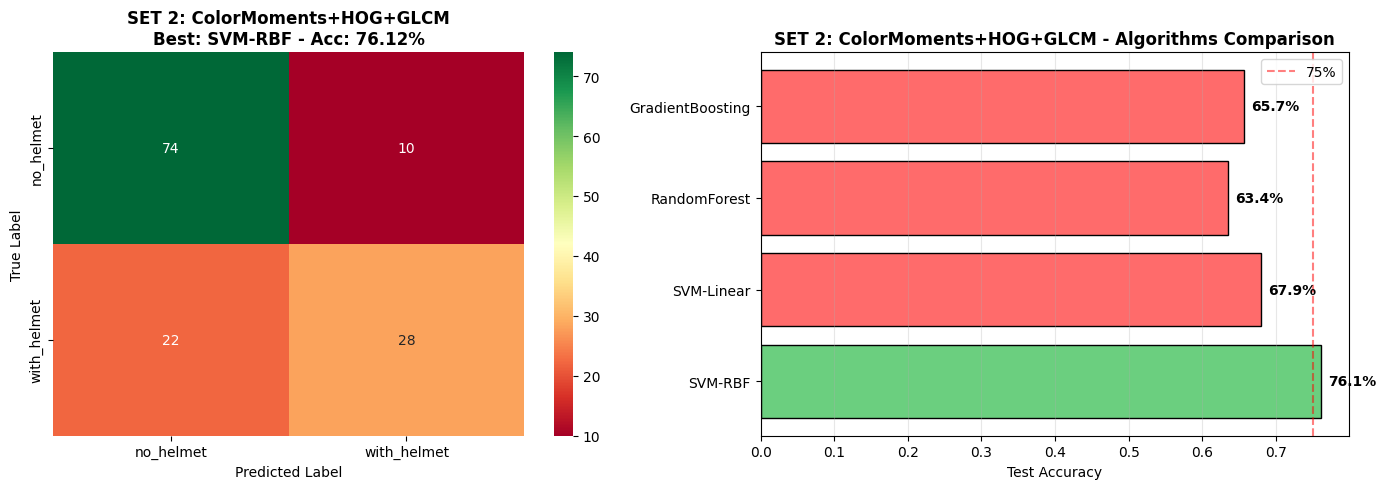


📋 Classification Report - Best Model (SVM-RBF):
              precision    recall  f1-score   support

   no_helmet       0.77      0.88      0.82        84
 with_helmet       0.74      0.56      0.64        50

    accuracy                           0.76       134
   macro avg       0.75      0.72      0.73       134
weighted avg       0.76      0.76      0.75       134


🔬 SET 3: EDGE + HOG + COLOR HISTOGRAM
📊 Extracting features...
✅ Features extracted: (1334, 1621)
   • Edge Features: 5 features (Canny + Sobel)
   • HOG: ~1568 features
   • Color Histogram: 48 features (16 bins × 3 channels)

🧪 RUNNING EXPERIMENTS: SET 3: Edge+HOG+ColorHist
📊 Data Split: Train=1067, Val=133, Test=134
   Train distribution: [665, 402]
⚖️ SMOTE applied: 1067 → 1330
📉 PCA: 1621 → 348 features (95% variance)

  🔹 Training SVM-RBF...
     Train: 0.9925 | Val: 0.8722 | Test: 0.7463 | Time: 0.28s

  🔹 Training SVM-Linear...
     Train: 1.0000 | Val: 0.7068 | Test: 0.6269 | Time: 1.13s

  🔹 Training Rando

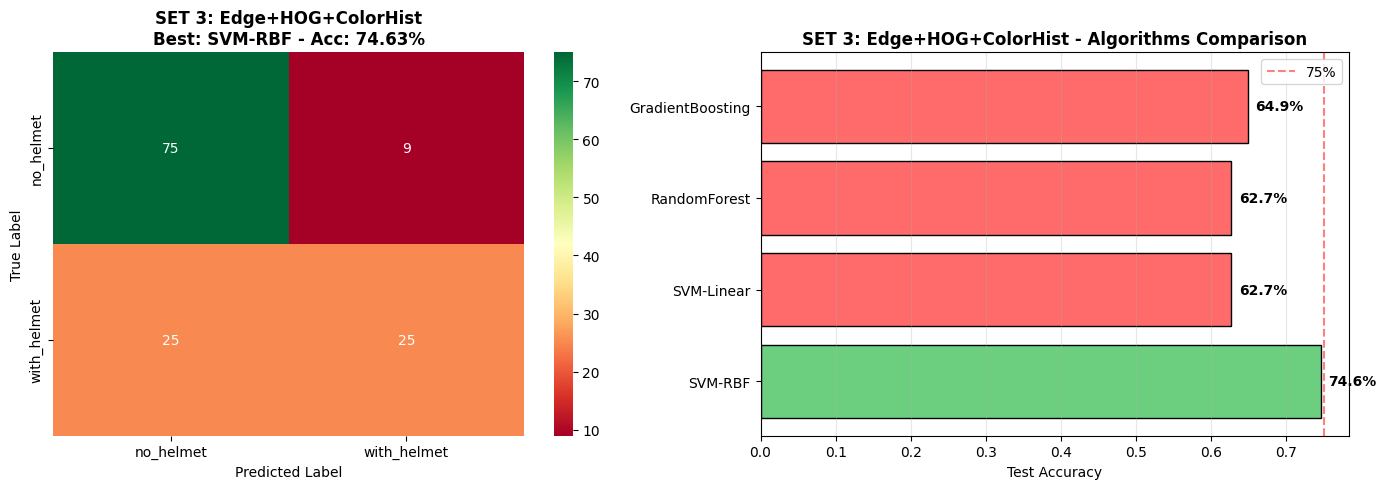


📋 Classification Report - Best Model (SVM-RBF):
              precision    recall  f1-score   support

   no_helmet       0.75      0.89      0.82        84
 with_helmet       0.74      0.50      0.60        50

    accuracy                           0.75       134
   macro avg       0.74      0.70      0.71       134
weighted avg       0.74      0.75      0.73       134


📊 PERBANDINGAN SEMUA SET

📋 TABEL PERBANDINGAN:
Feature Set        Algorithm Test Acc Val Acc Overfitting Time (s)
      SET 1          SVM-RBF   70.90%  80.45%      28.73%     0.53
      SET 1       SVM-Linear   67.16%  72.93%      32.84%     0.34
      SET 1     RandomForest   61.94%  67.67%      38.06%     3.14
      SET 1 GradientBoosting   65.67%  75.19%      34.33%    82.75
      SET 2          SVM-RBF   76.12%  81.95%      23.05%     0.37
      SET 2       SVM-Linear   67.91%  69.92%      32.09%     1.42
      SET 2     RandomForest   63.43%  65.41%      36.57%     3.56
      SET 2 GradientBoosting   65.67%  

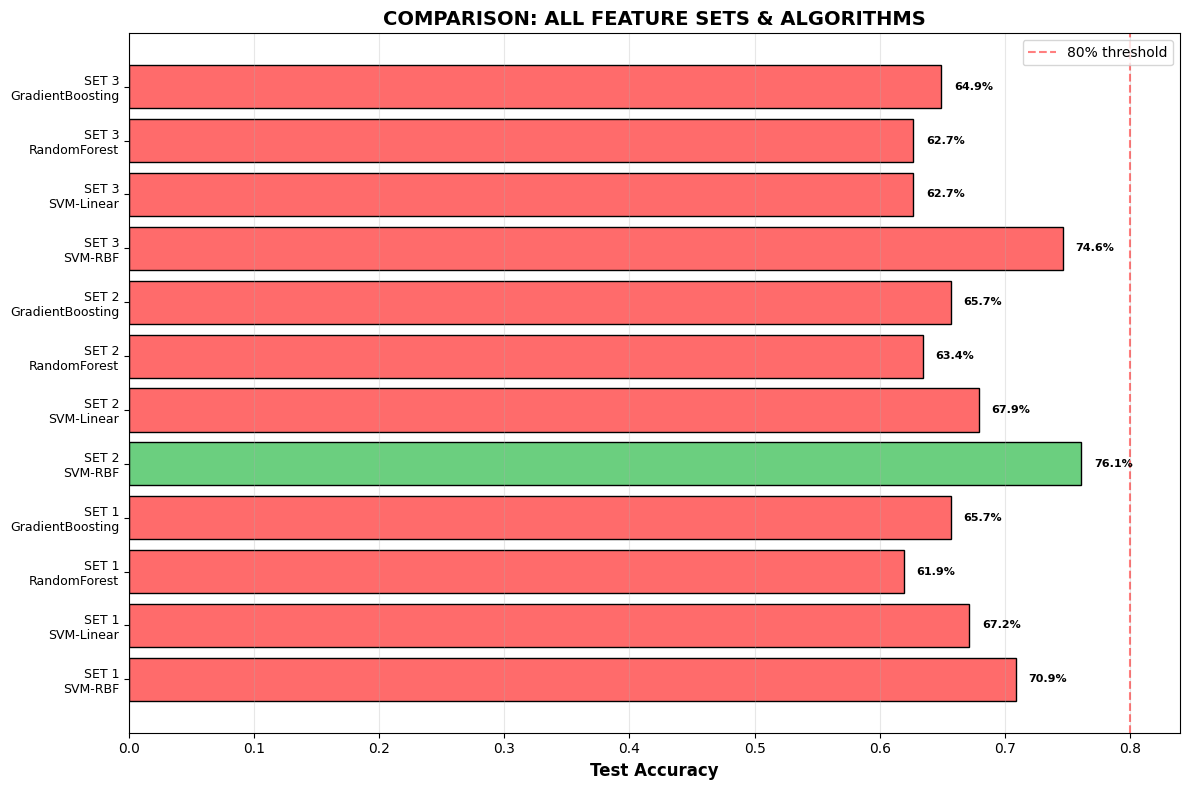


✅ SEMUA EKSPERIMEN SELESAI!


In [ ]:
# ================================================================================
# GOOGLE COLAB NOTEBOOK - ML 2-CLASS HELMET DETECTION
# ================================================================================
# Cara pakai:
# 1. Buat notebook baru di Google Colab
# 2. Copy paste setiap section ke cell terpisah
# 3. Run sequential dari atas ke bawah
# ================================================================================

# ================================================================================
# CELL 1: INSTALL & IMPORT LIBRARIES
# ================================================================================
print("="*80)
print("📚 TAHAP 1: INSTALL & IMPORT LIBRARIES")
print("="*80)

!pip install -q roboflow albumentations opencv-python scikit-learn scikit-image matplotlib seaborn imbalanced-learn

import os
import cv2
import yaml
import numpy as np
import pandas as pd
import albumentations as A
from roboflow import Roboflow
from skimage.feature import hog, local_binary_pattern, graycomatrix, graycoprops
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
from collections import Counter

print("✅ Libraries imported successfully!")

# ================================================================================
# CELL 2: LOAD DATASET
# ================================================================================
print("\n" + "="*80)
print("📥 TAHAP 2: LOAD DATASET DARI ROBOFLOW")
print("="*80)

rf = Roboflow(api_key="9J11qljgG9odzZnvoVbg")
project = rf.workspace("aa-cqfub").project("h3lm-40l0-oid-xd-3dofr")
version = project.version(5)
dataset = version.download("yolov11")

# Target classes
TARGET_CLASSES = {1: 0, 5: 1}  # 1=no_helmet→0, 5=with_helmet→1
CLASS_NAMES = ['no_helmet', 'with_helmet']

print(f"\n✅ Dataset downloaded!")
print(f"📁 Location: {dataset.location}")
print(f"🎯 Target Classes: {CLASS_NAMES}")

# ================================================================================
# CELL 3: PREPROCESSING & AUGMENTASI
# ================================================================================
print("\n" + "="*80)
print("🔧 TAHAP 3: PREPROCESSING & AUGMENTASI")
print("="*80)

# Define augmentation pipeline
transform_crop = A.Compose([
    A.Resize(128, 128),
    A.GaussianBlur(blur_limit=(3, 5), p=0.3),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=20, p=0.5),
])

print("✅ Preprocessing pipeline created:")
print("   • Resize: 128x128")
print("   • Gaussian Blur (noise reduction)")
print("   • Horizontal Flip")
print("   • Rotation ±15°")
print("   • Brightness/Contrast adjustment")
print("   • HSV color shift")

# ================================================================================
# CELL 4: HELPER FUNCTIONS
# ================================================================================
print("\n" + "="*80)
print("🛠️ TAHAP 4: HELPER FUNCTIONS")
print("="*80)

def yolo_to_bbox(x_center, y_center, width, height, img_width, img_height):
    """Convert YOLO format to pixel coordinates"""
    x_center *= img_width
    y_center *= img_height
    width *= img_width
    height *= img_height

    x1 = int(max(0, x_center - width / 2))
    y1 = int(max(0, y_center - height / 2))
    x2 = int(min(img_width, x_center + width / 2))
    y2 = int(min(img_height, y_center + height / 2))

    return x1, y1, x2, y2

def run_experiment(X, y, feature_name, algorithms_dict, show_plots=True):
    """Run experiments with multiple algorithms"""
    print(f"\n{'='*80}")
    print(f"🧪 RUNNING EXPERIMENTS: {feature_name}")
    print(f"{'='*80}")

    results = []

    # Split data
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
    )

    print(f"📊 Data Split: Train={len(y_train)}, Val={len(y_val)}, Test={len(y_test)}")
    print(f"   Train distribution: {np.bincount(y_train).tolist()}")

    # SMOTE
    class_counts = np.bincount(y_train)
    if abs(class_counts[0] - class_counts[1]) > 50:
        target_count = max(class_counts)
        try:
            smote = SMOTE(random_state=42, k_neighbors=5,
                         sampling_strategy={0: target_count, 1: target_count})
            X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)
            print(f"⚖️ SMOTE applied: {len(y_train)} → {len(y_train_bal)}")
        except:
            X_train_bal, y_train_bal = X_train, y_train
    else:
        X_train_bal, y_train_bal = X_train, y_train

    # Normalize
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_bal)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # PCA
    pca = PCA(n_components=0.95, random_state=42)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_val_pca = pca.transform(X_val_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    print(f"📉 PCA: {X.shape[1]} → {X_train_pca.shape[1]} features (95% variance)")

    # Train & evaluate each algorithm
    for algo_name, algorithm in algorithms_dict.items():
        print(f"\n  🔹 Training {algo_name}...")

        start = time.time()
        algorithm.fit(X_train_pca, y_train_bal)
        train_time = time.time() - start

        train_acc = accuracy_score(y_train_bal, algorithm.predict(X_train_pca))
        val_acc = accuracy_score(y_val, algorithm.predict(X_val_pca))
        test_acc = accuracy_score(y_test, algorithm.predict(X_test_pca))

        print(f"     Train: {train_acc:.4f} | Val: {val_acc:.4f} | Test: {test_acc:.4f} | Time: {train_time:.2f}s")

        results.append({
            'algorithm': algo_name,
            'train_acc': train_acc,
            'val_acc': val_acc,
            'test_acc': test_acc,
            'overfitting': train_acc - test_acc,
            'train_time': train_time,
            'model': algorithm,
            'y_test': y_test,
            'y_pred': algorithm.predict(X_test_pca)
        })

    # Find best
    best = max(results, key=lambda x: x['test_acc'])

    # Plot results
    if show_plots:
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        # Confusion matrix
        cm = confusion_matrix(best['y_test'], best['y_pred'])
        sns.heatmap(cm, annot=True, fmt='d', cmap='RdYlGn',
                   xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, ax=axes[0])
        axes[0].set_title(f"{feature_name}\nBest: {best['algorithm']} - Acc: {best['test_acc']:.2%}",
                         fontweight='bold')
        axes[0].set_ylabel('True Label')
        axes[0].set_xlabel('Predicted Label')

        # Bar comparison
        test_accs = [r['test_acc'] for r in results]
        algo_names = [r['algorithm'] for r in results]
        colors = ['#6bcf7f' if acc == max(test_accs) else '#ffd93d' if acc > 0.75 else '#ff6b6b'
                 for acc in test_accs]

        axes[1].barh(algo_names, test_accs, color=colors, edgecolor='black')
        axes[1].set_xlabel('Test Accuracy')
        axes[1].set_title(f'{feature_name} - Algorithms Comparison', fontweight='bold')
        axes[1].axvline(x=0.75, color='red', linestyle='--', alpha=0.5, label='75%')
        axes[1].legend()
        axes[1].grid(axis='x', alpha=0.3)

        for i, v in enumerate(test_accs):
            axes[1].text(v + 0.01, i, f'{v:.1%}', va='center', fontweight='bold')

        plt.tight_layout()
        plt.show()

        # Classification report
        print(f"\n📋 Classification Report - Best Model ({best['algorithm']}):")
        print(classification_report(best['y_test'], best['y_pred'],
                                   target_names=CLASS_NAMES, zero_division=0))

    return results, best

print("✅ Helper functions defined!")

# ================================================================================
# CELL 5: CROP BBOXES & PREPARE DATA
# ================================================================================
print("\n" + "="*80)
print("✂️ TAHAP 5: CROP BBOXES (MULTIPLE LABELS)")
print("="*80)

def load_cropped_data(dataset_path):
    """Load and crop all helmet bboxes"""
    print("📦 Loading and cropping bboxes...")

    all_images = []
    all_labels = []
    total_bboxes = 0

    for split in ['train', 'valid', 'test']:
        img_folder = os.path.join(dataset_path, split, "images")
        label_folder = os.path.join(dataset_path, split, "labels")

        if not os.path.exists(img_folder):
            continue

        image_files = [f for f in os.listdir(img_folder) if f.endswith(('.jpg', '.png'))]

        for img_file in image_files:
            img_path = os.path.join(img_folder, img_file)
            label_path = os.path.join(label_folder, img_file.replace('.jpg', '.txt').replace('.png', '.txt'))

            image = cv2.imread(img_path)
            if image is None:
                continue

            img_height, img_width = image.shape[:2]
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            if not os.path.exists(label_path):
                continue

            with open(label_path, 'r') as f:
                for line in f.readlines():
                    parts = line.strip().split()
                    if len(parts) == 5:
                        cls = int(parts[0])

                        if cls not in TARGET_CLASSES:
                            continue

                        x_c, y_c, w, h = map(float, parts[1:])
                        x1, y1, x2, y2 = yolo_to_bbox(x_c, y_c, w, h, img_width, img_height)

                        if (x2 - x1) < 10 or (y2 - y1) < 10:
                            continue

                        cropped = image_rgb[y1:y2, x1:x2]
                        if cropped.size == 0:
                            continue

                        try:
                            aug = transform_crop(image=cropped)
                            aug_img = np.clip(aug['image'], 0, 255).astype(np.uint8)
                            aug_img = cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR)

                            all_images.append(aug_img)
                            all_labels.append(TARGET_CLASSES[cls])
                            total_bboxes += 1
                        except:
                            continue

    print(f"✅ Processed: {total_bboxes} bboxes")
    print(f"   Distribution: {np.bincount(all_labels).tolist()} (0=no_helmet, 1=with_helmet)")

    return all_images, np.array(all_labels)

# Load cropped images
cropped_images, labels = load_cropped_data(dataset.location)
print(f"\n✅ Total cropped bboxes: {len(cropped_images)}")

# ================================================================================
# CELL 6: SET 1 - HISTOGRAM + HOG + LBP
# ================================================================================
print("\n" + "="*80)
print("🔬 SET 1: HISTOGRAM + HOG + LBP")
print("="*80)

def extract_set1_features(image):
    """Feature Set 1: Histogram + HOG + LBP"""
    # Histogram (Color Distribution)
    hist_features = []
    for i in range(3):
        hist = cv2.calcHist([image], [i], None, [32], [0, 256])
        hist = hist.flatten() / (hist.sum() + 1e-7)
        hist_features.extend(hist)

    # HOG (Shape/Edge)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hog_feat = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                   cells_per_block=(2, 2), block_norm='L2-Hys',
                   visualize=False, feature_vector=True)

    # LBP (Texture)
    lbp = local_binary_pattern(gray, 24, 3, method='uniform')
    n_bins = int(lbp.max() + 1)
    lbp_hist, _ = np.histogram(lbp, bins=n_bins, range=(0, n_bins), density=True)

    return np.concatenate([hist_features, hog_feat, lbp_hist])

print("📊 Extracting features...")
X_set1 = np.array([extract_set1_features(img) for img in cropped_images])
print(f"✅ Features extracted: {X_set1.shape}")
print(f"   • Histogram: 96 features (32 bins × 3 channels)")
print(f"   • HOG: ~{X_set1.shape[1] - 122} features")
print(f"   • LBP: ~26 features")

# Define algorithms
algorithms_set1 = {
    'SVM-RBF': SVC(kernel='rbf', C=1.0, gamma='scale', class_weight='balanced', random_state=42),
    'SVM-Linear': SVC(kernel='linear', C=0.5, class_weight='balanced', random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=42)
}

# Run experiments
results_set1, best_set1 = run_experiment(X_set1, labels, "SET 1: Histogram+HOG+LBP", algorithms_set1)

# ================================================================================
# CELL 7: SET 2 - COLOR MOMENTS + HOG + GLCM
# ================================================================================
print("\n" + "="*80)
print("🔬 SET 2: COLOR MOMENTS + HOG + GLCM")
print("="*80)

def extract_set2_features(image):
    """Feature Set 2: Color Moments + HOG + GLCM"""
    features = []

    # Color Moments (Mean, Std, Skewness)
    for i in range(3):
        channel = image[:,:,i].astype(np.float64)
        mean_val = np.mean(channel)
        std_val = np.std(channel)
        centered = channel - mean_val
        skew_val = np.mean(centered**3) / (std_val**3 + 1e-7)
        features.extend([mean_val, std_val, skew_val])

    # HOG (optimized)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hog_feat = hog(gray, orientations=9, pixels_per_cell=(16, 16),
                   cells_per_block=(2, 2), block_norm='L2-Hys',
                   visualize=False, feature_vector=True)

    # GLCM (Texture)
    gray_norm = (gray / 16).astype(np.uint8)
    glcm = graycomatrix(gray_norm, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                        levels=16, symmetric=True, normed=True)

    glcm_features = []
    for prop in ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']:
        glcm_features.extend(graycoprops(glcm, prop).flatten())

    return np.concatenate([features, hog_feat, glcm_features])

print("📊 Extracting features...")
X_set2 = np.array([extract_set2_features(img) for img in cropped_images])
print(f"✅ Features extracted: {X_set2.shape}")
print(f"   • Color Moments: 9 features (mean, std, skew × 3 channels)")
print(f"   • HOG: ~{X_set2.shape[1] - 29} features")
print(f"   • GLCM: ~20 features")

algorithms_set2 = {
    'SVM-RBF': SVC(kernel='rbf', C=1.0, gamma='scale', class_weight='balanced', random_state=42),
    'SVM-Linear': SVC(kernel='linear', C=0.5, class_weight='balanced', random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=42)
}

results_set2, best_set2 = run_experiment(X_set2, labels, "SET 2: ColorMoments+HOG+GLCM", algorithms_set2)

# ================================================================================
# CELL 8: SET 3 - EDGE + HOG + COLOR HISTOGRAM
# ================================================================================
print("\n" + "="*80)
print("🔬 SET 3: EDGE + HOG + COLOR HISTOGRAM")
print("="*80)

def extract_set3_features(image):
    """Feature Set 3: Edge + HOG + Color Histogram"""
    features = []
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Edge Features (Canny + Sobel)
    edges_canny = cv2.Canny(gray, 50, 150)
    features.extend([
        np.sum(edges_canny > 0) / edges_canny.size,
        np.mean(edges_canny),
        np.std(edges_canny)
    ])

    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    features.extend([np.mean(np.abs(sobelx)), np.mean(np.abs(sobely))])

    # HOG (compact)
    hog_feat = hog(gray, orientations=8, pixels_per_cell=(16, 16),
                   cells_per_block=(2, 2), block_norm='L2-Hys',
                   visualize=False, feature_vector=True)

    # Color Histogram (reduced)
    hist_features = []
    for i in range(3):
        hist = cv2.calcHist([image], [i], None, [16], [0, 256])
        hist = hist.flatten() / (hist.sum() + 1e-7)
        hist_features.extend(hist)

    return np.concatenate([features, hog_feat, hist_features])

print("📊 Extracting features...")
X_set3 = np.array([extract_set3_features(img) for img in cropped_images])
print(f"✅ Features extracted: {X_set3.shape}")
print(f"   • Edge Features: 5 features (Canny + Sobel)")
print(f"   • HOG: ~{X_set3.shape[1] - 53} features")
print(f"   • Color Histogram: 48 features (16 bins × 3 channels)")

algorithms_set3 = {
    'SVM-RBF': SVC(kernel='rbf', C=1.0, gamma='scale', class_weight='balanced', random_state=42),
    'SVM-Linear': SVC(kernel='linear', C=0.5, class_weight='balanced', random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=42)
}

results_set3, best_set3 = run_experiment(X_set3, labels, "SET 3: Edge+HOG+ColorHist", algorithms_set3)

# ================================================================================
# CELL 9: COMPARISON ALL SETS
# ================================================================================
print("\n" + "="*80)
print("📊 PERBANDINGAN SEMUA SET")
print("="*80)

# Compile all results
all_results = []
for set_name, results in [('SET 1', results_set1), ('SET 2', results_set2), ('SET 3', results_set3)]:
    for r in results:
        all_results.append({
            'Feature Set': set_name,
            'Algorithm': r['algorithm'],
            'Test Acc': f"{r['test_acc']:.2%}",
            'Val Acc': f"{r['val_acc']:.2%}",
            'Overfitting': f"{r['overfitting']:.2%}",
            'Time (s)': f"{r['train_time']:.2f}"
        })

# Display table
df_comparison = pd.DataFrame(all_results)
print("\n📋 TABEL PERBANDINGAN:")
print(df_comparison.to_string(index=False))

# Find overall best
best_overall = max([best_set1, best_set2, best_set3], key=lambda x: x['test_acc'])
set_names = {id(best_set1): 'SET 1', id(best_set2): 'SET 2', id(best_set3): 'SET 3'}

print(f"\n🏆 BEST OVERALL:")
print(f"   Feature Set: {set_names[id(best_overall)]}")
print(f"   Algorithm: {best_overall['algorithm']}")
print(f"   Test Accuracy: {best_overall['test_acc']:.2%}")
print(f"   Val Accuracy: {best_overall['val_acc']:.2%}")
print(f"   Overfitting: {best_overall['overfitting']:.2%}")

# Visual comparison
fig, ax = plt.subplots(figsize=(12, 8))

test_accs = [float(r['Test Acc'].rstrip('%'))/100 for r in all_results]
labels = [f"{r['Feature Set']}\n{r['Algorithm']}" for r in all_results]
colors = ['#6bcf7f' if acc == max(test_accs) else '#ffd93d' if acc > 0.75 else '#ff6b6b'
         for acc in test_accs]

ax.barh(range(len(test_accs)), test_accs, color=colors, edgecolor='black')
ax.set_yticks(range(len(labels)))
ax.set_yticklabels(labels, fontsize=9)
ax.set_xlabel('Test Accuracy', fontweight='bold', fontsize=12)
ax.set_title('COMPARISON: ALL FEATURE SETS & ALGORITHMS', fontweight='bold', fontsize=14)
ax.axvline(x=0.80, color='red', linestyle='--', alpha=0.5, label='80% threshold')
ax.legend()
ax.grid(axis='x', alpha=0.3)

for i, v in enumerate(test_accs):
    ax.text(v + 0.01, i, f'{v:.1%}', va='center', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.savefig('comparison_all_sets.png', dpi=300, bbox_inches='tight')
print("\n✅ Comparison chart saved: comparison_all_sets.png")
plt.show()

print("\n" + "="*80)
print("✅ SEMUA EKSPERIMEN SELESAI!")
print("="*80)

In [ ]:
# @title
# Load model (masih error gtau knp)
# Modified to load the specifically saved best model for SET 2
# The 'best_overall_model.pkl' might contain mismatched components based on the traceback.
with open('/content/drive/MyDrive/jurnal YOLO/Machine Learning/hasil colab/best_model_set_2.pkl', 'rb') as f:
    saved_data = pickle.load(f)

model = saved_data['model']
scaler = saved_data['scaler']
pca = saved_data['pca']
feature_extractor = saved_data['feature_extractor'] # Load the correct feature extractor

# Inference pada image baru
new_image_path = '/content/test helm.webp' # Path to your new image
new_image = cv2.imread(new_image_path)

if new_image is None:
    print(f"Error: Image not found at {new_image_path}")
else:
    # Ensure the image is in the correct color format (BGR for OpenCV)
    # The feature extractors expect BGR
    # new_image = cv2.cvtColor(new_image, cv2.COLOR_RGB2BGR) # Already BGR if read by cv2.imread

    try:
        features = feature_extractor(new_image)
        features_scaled = scaler.transform([features])
        features_pca = pca.transform(features_scaled)
        prediction = model.predict(features_pca)

        print(f"Prediction for {os.path.basename(new_image_path)}: {saved_data['class_names'][prediction[0]]}")
    except Exception as e:
        print(f"Error during feature extraction or prediction: {e}")

Error during feature extraction or prediction: X has 3269 features, but StandardScaler is expecting 1793 features as input.
